In [1]:
# Libraries used in this notebook
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from PIL import Image

# Capstone project by Christel CHAPPUIS 

# Explorations in Arts

## Data preparation - EDA

### Context

- What is the wider context of your problem and what story you would like to tell with the data?
- What problem would you like to address?

For a few years now, I have developed a keen interest for Arts. It conveys a message, sometimes in beautiful shapes but not always. It can also provide a story of historical events, make us witness different times. It is a unique mean of communication throughout centuries. In my humble opinion, a 'good' piece of art has a certain power over us, it can create an emotion, sometimes troubling feelings, but must importantly for me it stimulates my natural curiosity.

There would be a lot to say about this general topic but in particular I want to highlight the large variety of pieces considered artistic. It is present in every corner of the world and from the prehistorical times to nowadays. This observation makes me believe that there are some very interesting tasks to perform with data analytics and machine learning in this field. Obviously, opportunities are quite dependant on the accessibility of data, from meta information to images. Luckily, some museums have started on their path of digitalization and can now provide a large access of their collection through the internet. 

When I consider what makes a piece artistic, besides the aspect of communication and emotion mentionned above, I often wonder about the signature of each artist. Following this idea, a goal that really motivates me would be, ultimately, to recognize an artist when observing his/her pieces. Maybe, sometimes in the future, machine learning can help experts in the attribution of anonymous art pieces to a certain artist. In a less positive note, I am wondering whether the knowledge that can store and be leverable by a computer could help in the identification of forgeries. Although these are very motivating tasks, it might be a little out of reach for my current skills in this project. Indeed, these tasks can be already extremely challenging for field experts, for example numerous art pieces remain to this day unattributed. Technically, it would most probably requires hundreds of thousands of images to process in a rather complex architecture. 

Nevertheless, there are other interesting, a little bit more reasonnable tasks in relation to the domain of Arts. Museums can be large organization and have a very extensive collection in extremely various forms, ages, origins etc. The museum thus needs to be organized in some way in order to function correctly. For example, it can be organized in different departments, as it is the case for the Metropolitan museum of Arts. Each piece is assigned to a curatorial department, which is responsible for the artwork. A question emerges here, let's say I am a new collaborator at the Met and have been given some tasks to perform on a few art pieces. Luckily, I have some information about these art pieces but I am unfortunately unaware of the department where I can find them. Given the information I have, can I predict where, meaning in which department, I should find the pieces ?

After this first pratical question, I would like to investigate more learning transfer in computer vision, carrying on from the last chapters and project of course 4. I am aware most models available in TensorFlow or Keras hub are trained on ImageNet dataset and would like to find out how well they can classify objects in the field of Arts. For example, pieces can be classified by general type categories, i.e. it can be a painting, a drawing, a sculpture, so on and so forth. So the problem is, given a photograph of the art piece, is it possible to classify the art pieces into general type categories. Which already pretrained models available in TensorFlow/Keras Hub performs better? And finally, can we improve the classification by giving "metadata" information to the model, such as the artist information, the period or date, the geographical location and more? 

Other types of classification might turn out to be very interesting machine learning challenges as well. For example, I would find interesting to investigate in more details paintings. Given their photographic representation, and possibly metadata, can we train models to recognize the art movement: Renaissance, Impressionism, Cubism, etc ? However, in the context of this project, I plan on focusing on the two tasks shortly described above. 

## The data

The data source that I will use is the Metropolitan Museum of Art catalogue and online database. The museum provides a large list of its collection, with various types of pieces. I retrieved the text data from the github repository: https://github.com/metmuseum/openaccess In addition to the text data, I would like to download images of Open Access art pieces. To do so, I follow the indications here: https://metmuseum.github.io/ and I wrote a small code to download the image file from each image url. 
In order to avoid any issues with legal rights, I will only use data for the art pieces labelled as 'Open Access' by the Metropolitan Museum of Art.

**First insights into the data**

There is a total of 474'526 samples in the catalogue, described by 54 features. 
I identified the following groups of features: 
- object identification and management in the museum (object number and ID, Gallery number, Department, AccessionYear, Object Name, Title)
- 3 boolean features to define whether the piece is in highlight, in the timeline work and of public domain
- features describing the object physically (Medium, Dimensions)
- features about the artist
- features locating the origin of the piece or where it was found (Culture, Excavation, River)
- Miscellaneous

The encoding of each feature from the file directly is displayed below thanks to the .info() method.

With 54 possible features in total, art pieces are described with a relatively important level of details. However some features are poorly filled, such as the geographical origin of the piece.

Quality of the data: as mentionned, some features are missing a large proportion of their values. Besides the missing values, the dataset does not seem to have incorrect values as far as I can tell. Nevertheless, given that most features is of type 'object' and contains a large variety of categorical values, incorrect values are not trivial to identify. Rather than incorrect, it seems the features are often described in many different values that sometimes convey the same meaning. Features are thus not well standardized, which is an issue for my ML tasks. 

### Data management plan

**Managing data ex. storing, file formats, database usage**

Regarding the text file, the file is relatively heavy but can be loaded in one step into this Jupyter Notebook. In order to avoid any issue with rights, I have decided to use only the data points with a "True" value in the feature "Is Public Domain". Once this step is done, I save a second text file containing only the Open Access pieces. Thus, whenever I have to load again the text file into a dataframe, I can use this second, smaller by a factor of about 2, text file to save time and RAM.

For the second task involving images, my computer probably cannot manage downloading, storing, processing and running models on this amount of images. Thus, I will make a selection of pieces to analyze with images. Again, I will only work on Open Access pieces. I am considering focusing on pieces currently in highlight. This feature identifies art pieces currently under the spotlight. I will possibly focus only on a subset of the type categories (features 'Object Name' and/or 'Classification').

**Data cleaning and data manipulation**

One of the challenge I see is that most of the features have text, categorical values. Thus, the encoding is going to be an important part of the data processing. Especially, I will keep an eye on the number of features after encoding, considering the curse of dimensionality (p>>n). Indeed, there is a risk a one-hot encoding might lead to too many columns and cause issues.

For the dates (and Accession Year), I will make the necessary changes in order to have a number (int64) instead of a text (object).

For the dimensions, I would like to extract numerical values in two columns instead of a text. 

More generally, some features will be removed because too few data points have values for them. Some features might be generalized, meaning I will try to define a common, more general value for values that are too detailed and present only in very few data points. Some features might be removed if the information seems irrelevant to the tasks described.

**Feature engineering**

I decided to create a feature 'Artist Century' to represent a more generalized time of existence for the person considered as artist.

In [2]:
# After the first time, run this cell to upload the data (instead of the previous one)
df = pd.read_csv('MetOBjectsOA.txt',sep='\t',low_memory=False)

In [3]:
# How many of the Open Access pieces are in highlights ?
df['Is Highlight'].sum()

1608

In [4]:
# Which department do we have in highlights ?
df[df['Is Highlight']==True][['Is Highlight', 'Department']].groupby('Department').count().sort_values('Is Highlight',ascending=False).head(16).T

Department,The American Wing,Islamic Art,European Paintings,Greek and Roman Art,Egyptian Art,The Libraries,Musical Instruments,Robert Lehman Collection,European Sculpture and Decorative Arts,Ancient Near Eastern Art,"Arts of Africa, Oceania, and the Americas",The Cloisters,Drawings and Prints,Asian Art,Medieval Art,Arms and Armor
Is Highlight,299,119,117,115,114,103,84,83,80,75,66,58,57,55,54,53


In [5]:
# What type of art do we have in highlights ?
df[df['Is Highlight']==True][['Is Highlight', 'Classification']].groupby('Classification').count().sort_values('Is Highlight',ascending=False).head(16).T

Classification,Paintings,Drawings,Sculpture,|,Codices,Ceramics,Photographs,Stone Sculpture,Furniture,Glass,Textiles,Vases,Prints,Bronzes,(not assigned),Metalwork-Silver
Is Highlight,277,93,54,51,43,40,39,39,38,28,26,23,22,20,18,17


## Exploratory data analysis (EDA) and data cleaning

As my first impression was especially concerned about the majority of features being categorical, I would like to find out how many values exist for each feature.

In [6]:
feats = df.columns.tolist()
feats_table = pd.DataFrame(columns=['Feature','UniqueV'])

for feat in feats:
    line = pd.DataFrame(data=[[feat,df[feat].nunique()]],columns=['Feature','UniqueV'])
    feats_table = feats_table.append(line,ignore_index=True)
    
feats_table.set_index('Feature', inplace=True)
feats_table

,UniqueV
Feature,
Object Number,238621
Is Highlight,2
Is Timeline Work,2
Object ID,239371
Gallery Number,373
Department,19
AccessionYear,152
Object Name,18770
Title,100697


In addition to the features being mostly categorical, another clear challenge is the quantity of unique values for each features. When it will come to encode these for the model, it might become problematic (curse of dimensionality). 

It is observed that a good object identifier for each data point is in the feature "Object ID". "Object Number" although promising is not absolutely unique, it will thus be removed.

With this in mind, let's go through all features in groups.

### Department, Classification, Object Name, Title, Object Number, Object ID, Gallery Number

The first task of this project is to predict the department in which the art piece can be found. Consequently, the target variable is "Department" and the model will classify each data point into on of the departments. This task is interesting because it seems that the focus of each department can be linked to different features of the dataset. Based on the list of department below, some departments are defined by the culture, the geographical origin, or from the type of art piece.

In [7]:
df[['Object ID','Department']].groupby('Department').count().sort_values(by='Object ID', ascending=False)

,Object ID
Department,
Drawings and Prints,61326
European Sculpture and Decorative Arts,31832
Asian Art,30781
Greek and Roman Art,29628
Egyptian Art,12861
Islamic Art,12646
The American Wing,11568
Costume Institute,7724
Medieval Art,6844


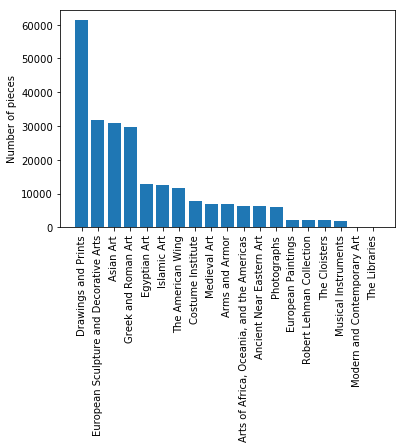

In [8]:
plt.bar(x = df[['Object ID','Department']].groupby('Department').count().sort_values(by='Object ID', ascending=False).index, 
        height = df[['Object ID','Department']].groupby('Department').count().sort_values(by='Object ID', ascending=False)['Object ID'])
plt.xticks(rotation=90)
plt.ylabel('Number of pieces')
plt.show()

To respond to Panagiota's comment below, I have run a short loop to assess whether a same object could be in two different departements. 

Panagiota's comment / question : Are the categories available in the "Department" column mutually exclusive (which means that a given sample can only belong to one of the categories available)? For example, can a sample belong both to the "Robert Lehman Collection" and "Drawings and Prints" categories?

In [9]:
dupl_Onum = df['Object Number'].value_counts()[df['Object Number'].value_counts()>1]
sameO_difT = 0
sameO_sameT_sameD = 0
sameO_sameT_difD = 0
for number in dupl_Onum.index.tolist():
    if df[df['Object Number'] == number]['Title'].nunique(dropna=False) == 1:
        if df[df['Object Number'] == number]['Department'].nunique(dropna=False) == 1:
            print(df[df['Object Number'] == number]['Object Number'])
            sameO_sameT_sameD = sameO_sameT_sameD +1 
        else: 
            sameO_sameT_difD = sameO_sameT_difD +1
                
    else:
        sameO_difT = sameO_difT +1

print('Same object number, same title, same department. Number of duplicates: ',sameO_sameT_sameD)
print('Same object number, same title, different department. Number of duplicates: ', sameO_sameT_difD)
print('Same object number, different title. Number of duplicates: ', sameO_difT)

205410    49.95.868(3)
205412    49.95.868(3)
Name: Object Number, dtype: object
Same object number, same title, same department. Number of duplicates:  1
Same object number, same title, different department. Number of duplicates:  0
Same object number, different title. Number of duplicates:  749


There are several objects with identical 'Object Number' but different 'Title' (749 occurences). There is only one object with both identical 'Object Number' and 'Title', and it is located in the same department. With the feature 'Link Resource', I was able to visit the webpages of these two samples with identical number, title and department. It appears to be the exact same piece but with different ID. I decide to remove one of the sample, considered as duplicate.
- https://www.metmuseum.org/art/collection/search/666286
- https://www.metmuseum.org/art/collection/search/666288

From this observation, I conclude there is no sample that is present in two departments at the same time. The 'Department' column is mutually exclusive. 

In [10]:
df.drop(205412,axis='index', inplace=True)

Department categories are imbalanced, this is a characteristic that complicates a little a machine learning task but should be manageable with proper care. 

Nevertheless, some classes are very little represented, in particular 'Modern and Contemporary Art' and 'The Libraries'. I decided to remove samples belonging to this class altogether. I am considering the same fate for 'European Paintings', 'Robert Lehman Collection', 'The Cloisters', 'Musical Instruments' but have not decided yet. I will go through all cleaning steps and reassess the situation at the end.

In [11]:
df.drop(df[df.Department == 'Modern and Contemporary Art'].index, inplace=True)
df.drop(df[df.Department == 'The Libraries'].index, inplace=True)

Let's now compare the feature 'Classification' with the feature 'Object Name'. 

First, I compare the types of entries for these two features. In doing so, I focus in particular at the most frequent occurences.

In [12]:
for feat in ['Classification','Object Name']:
    counts = df[feat].value_counts().head(10)
    print(feat)
    print(counts)
    print('\n')

Classification
Prints                  32031
Vases                   20020
Drawings                14497
Ceramics                11454
Textiles-Woven           7822
Photographs|Ephemera     7280
Glass                    6720
Paintings                6366
Photographs              5819
Prints|Ephemera          5376
Name: Classification, dtype: int64


Object Name
Print             36330
Drawing           14419
Photograph         9089
Kylix fragment     8886
Fragment           8128
Piece              6426
Painting           3037
Bowl               2841
Figure             2309
Vase               2180
Name: Object Name, dtype: int64




In [13]:
print('Classification: ', round(df.Classification.notna().sum()/df.shape[0]*100,2), '%')
print('Object Name: ', round(df['Object Name'].notna().sum()/df.shape[0]*100,2), '%')
feats_table.loc[['Classification', 'Object Name']]

Classification:  91.87 %
Object Name:  99.94 %


,UniqueV
Feature,
Classification,910
Object Name,18770


As we can see, both features store similar type of information. Unfortunately, I am unable to explain the differences between both features in terms of meaning or motivation. 

When looking at missing values, both features are relatively complete, although 'Object Name' is slightly more than 'Classification'.

Finally, there is a lot more different values in the category 'Object Name' than 'Classification'. 

Based on these observations, I decide to keep only 'Classification'. When possible, missing values in 'Classification' will be completed by 'Object Name', otherwise by 'Unknown'. 

In [14]:
df['Classification'].fillna(df['Object Name'], inplace=True)
df['Classification'].fillna('Miscellaneous', inplace=True)
df.drop(columns='Object Name', inplace=True)

Let's investigate the distribution of the number of occurences through the different values present in the features 'Classification'

In [15]:
test= df['Classification'].str.split(pat=',',
                               expand=True)[0].str.split(pat='|',
                                                         expand=True)[0].str.split(pat='-',
                                                                                   expand=True)[0].str.split(pat=':',
                                                                                                             expand=True)[0].str.split(pat=' \(',
                                                                                                                                       expand=True)[0].value_counts()

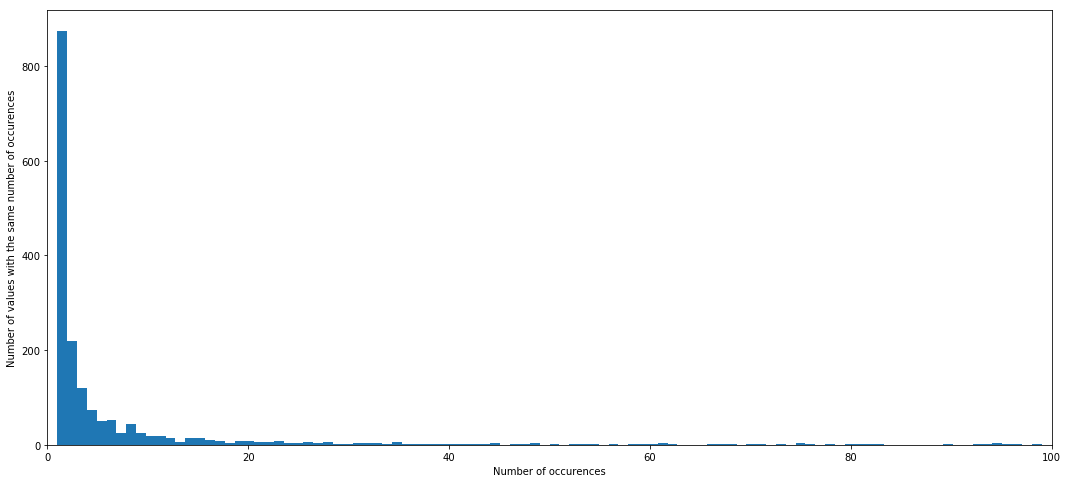

In [16]:
plt.figure(figsize=(18,8))
plt.hist(test[test < 101],bins=100)
plt.xlim(0,100)
plt.xlabel('Number of occurences')
plt.ylabel('Number of values with the same number of occurences')
plt.show()

The majority of values appear only a very few times throughout the feature 'Classification'. This is an issue. I thus decided to group all values appearing only a few times into one single value 'Other'. As I will have to proceed with the same strategy on several features, I made a function of it to later save some time.

In [17]:
df['Classification'] = df['Classification'].str.split(pat=',',
                               expand=True)[0].str.split(pat='|',
                                                         expand=True)[0].str.split(pat='-',
                                                                                   expand=True)[0].str.split(pat=':',
                                                                                                             expand=True)[0].str.split(pat=' \(',
                                                                                                                                       expand=True)[0]

In [18]:
def group_few_values(col_name, limit):
    U_col = df[col_name].value_counts()
    zip_sparse = zip(U_col[U_col<limit].index.tolist(), ['Other']*len(U_col[U_col<limit].index.tolist()))
    dict_col = dict(zip_sparse)
    df[col_name].replace(to_replace=dict_col, inplace=True)
    print('Number of unique values for the column', col_name,':', df[col_name].nunique())

In [19]:
group_few_values('Classification',10)

Number of unique values for the column Classification : 383


As I want to use this feature as target for the second machine learning task, I decide to do some further cleaning of the feature 'Classification'.

In [20]:
df['Classification'] = df['Classification'].replace(to_replace='',value='Miscellaneous')
df['Classification'] = df['Classification'].replace(to_replace='(not assigned)',value='Miscellaneous')

df['Classification'] = df['Classification'].replace(to_replace='Metal',value='Metalwork')

df['Classification'] = df['Classification'].replace(to_replace='Wood',value='Woodwork')
df['Classification'] = df['Classification'].replace(to_replace='Woodblocks',value='Woodwork')

df['Classification'] = df['Classification'].replace(to_replace='Vases',value='Vase')
df['Classification'] = df['Classification'].replace(to_replace='Vase fragment',value='Vase')
df['Classification'] = df['Classification'].replace(to_replace='Model vase',value='Vase')

df['Classification'] = df['Classification'].replace(to_replace='Tools',value='Tool')

df['Classification'] = df['Classification'].replace(to_replace='Coins',value='Coin')

df['Classification'] = df['Classification'].replace(to_replace='Illustrated Books',value='Books')
df['Classification'] = df['Classification'].replace(to_replace='Books & Manuscripts',value='Books')
df['Classification'] = df['Classification'].replace(to_replace='Books and book bindings',value='Books')

df['Classification'] = df['Classification'].replace(to_replace='Bone/Ivory',value='Ivory/Bone')
df['Classification'] = df['Classification'].replace(to_replace='Ivories and Bone',value='Ivory/Bone')

df['Classification'] = df['Classification'].replace(to_replace='Jewelry Set',value='Jewelry')

df['Classification'] = df['Classification'].replace(to_replace='Earring',value='Earrings')

df['Classification'] = df['Classification'].replace(to_replace='Seal amulet',value='Amulet')
df['Classification'] = df['Classification'].replace(to_replace='Bead amulet',value='Amulet')
df['Classification'] = df['Classification'].replace(to_replace='Amulet plaque',value='Amulet')

df['Classification'] = df['Classification'].replace(to_replace='Medals and Plaquettes',value='Medals')

df['Classification'] = df['Classification'].replace(to_replace='Glass rod',value='Glass')

df['Classification'] = df['Classification'].replace(to_replace='Afternoon dress',value='Dress')
df['Classification'] = df['Classification'].replace(to_replace='Morning dress',value='Dress')
df['Classification'] = df['Classification'].replace(to_replace='Robe à la Française',value='Dress')
df['Classification'] = df['Classification'].replace(to_replace='Dressing Gown',value='Dress')
df['Classification'] = df['Classification'].replace(to_replace='Dinner dress',value='Dress')
df['Classification'] = df['Classification'].replace(to_replace='Ball gown',value='Dress')
df['Classification'] = df['Classification'].replace(to_replace='Main dress',value='Dress')
df['Classification'] = df['Classification'].replace(to_replace='Walking dress',value='Dress')
df['Classification'] = df['Classification'].replace(to_replace="Robe à l'Anglaise",value='Dress')
df['Classification'] = df['Classification'].replace(to_replace='Robe',value='Dress')
df['Classification'] = df['Classification'].replace(to_replace='Visiting dress',value='Dress')
df['Classification'] = df['Classification'].replace(to_replace='Robe à la Polonaise',value='Dress')
df['Classification'] = df['Classification'].replace(to_replace='Evening dress',value='Dress')
df['Classification'] = df['Classification'].replace(to_replace='Christening Dress',value='Dress')
df['Classification'] = df['Classification'].replace(to_replace='Wedding Dress',value='Dress')
df['Classification'] = df['Classification'].replace(to_replace='Mourning dress',value='Dress')
df['Classification'] = df['Classification'].replace(to_replace='Mourning Dress',value='Dress')
df['Classification'] = df['Classification'].replace(to_replace='Tea gown',value='Dress')

df['Classification'] = df['Classification'].replace(to_replace='Top hat',value='Hat')
df['Classification'] = df['Classification'].replace(to_replace='Evening hat',value='Hat')

df['Classification'] = df['Classification'].replace(to_replace='Hairpin',value='Hair Accessory')
df['Classification'] = df['Classification'].replace(to_replace='Hair pin',value='Hair Accessory')
df['Classification'] = df['Classification'].replace(to_replace='Headdress',value='Hair Accessory')

df['Classification'] = df['Classification'].replace(to_replace='Evening slippers',value='Slippers')
df['Classification'] = df['Classification'].replace(to_replace='Wedding Slippers',value='Slippers')

df['Classification'] = df['Classification'].replace(to_replace='Evening gloves',value='Gloves')

df['Classification'] = df['Classification'].replace(to_replace='Court Suit',value='Suit')
df['Classification'] = df['Classification'].replace(to_replace='Evening suit',value='Suit')

df['Classification'] = df['Classification'].replace(to_replace='Funerary Figure',value='Funerary figure')
df['Classification'] = df['Classification'].replace(to_replace="Sculptor's Model/votive", value="Sculptor's model/votive")
df['Classification'] = df['Classification'].replace(to_replace='Ornament', value='Ornament & Architecture')
df['Classification'] = df['Classification'].replace(to_replace='model', value='Model')

print('Number of unique values for the column Classification:', df['Classification'].nunique())
# Manual changes made by reviewing the list of classification values
#df['Classification'].value_counts().index.tolist()

Number of unique values for the column Classification: 344


Let's have a look at a few 'Title' entries. Unfortunately, I will remove this feature. It might be key for the user and to identify an object (along the 'Object ID'), but I am unable to use it for the classification task. 

As explained above, I will keep 'Object ID' as unique identifier for each art piece, but remove 'Object Number' that shows some duplicates.

In [21]:
df['Title'][np.random.randint(df.shape[0], size=5)]

238869    "The Hat of the Bride" from The Songs of Béranger
137397      Courthouse at Richmond, Staten Island, New York
26334                                                   NaN
38151                                                   NaN
36141                                                   NaN
Name: Title, dtype: object

In [22]:
df.drop(columns=['Title','Object Number'], inplace=True)

Finally, let's have a look at the feature 'Gallery Number'.

In [23]:
print('Gallery Number, % of missing values: ', round(df['Gallery Number'].isna().sum()/df.shape[0]*100,2), '%')
print('Gallery Number, number of numeric values: ', df['Gallery Number'].str.isnumeric().value_counts()[1])
print('Gallery Number, number of non-null values: ', df['Gallery Number'].notna().sum())
print('Gallery Number, number of unique values: ', df['Gallery Number'].nunique())

df['Gallery Number'][np.random.randint(df.shape[0], size=5)]

Gallery Number, % of missing values:  84.77 %
Gallery Number, number of numeric values:  36410
Gallery Number, number of non-null values:  36411
Gallery Number, number of unique values:  369


27115    NaN
82910    NaN
60963    NaN
42435    NaN
25940    NaN
Name: Gallery Number, dtype: object

Although there is a very high percentage of missing values, I decide to keep the feature and replace missing values with 0. I chose 0 instead of 'Unknown' because (almost) all non-null values are numeric. I would prefer to have a numerical feature instead of a categorical one because it is probable the distance in number can relate to a physical distance. By this I mean, two galleries with close numbers could be neighboring in the museum buildings.

There is one piece of art that has a 'Gallery Number' that is not digits, instead the 'Gallery Number' is *Petrie Ct. Café*. Because there is only one single such occurence, I decide to remove this value and replace it with the missing value tag *0*.

In [24]:
df['Gallery Number'].fillna(0, inplace=True)
df.at[71823,'Gallery Number'] = 0
df['Gallery Number'] = pd.to_numeric(df['Gallery Number'])

### Dates : AccessionYear, Object Date, Object Begin Date, Object End Date

Let's investigate the features providing information about the time of each piece. These features have very few or even no missing values as we can see just below.

A few words to explain what the features 'Object Begin Date' and 'Object End Date' mean. These definitions are from this [link](https://metmuseum.github.io/).
- Object Begin Date: Machine readable date indicating the year the artwork was started to be created
- Object End Date: Machine readable date indicating the year the artwork was completed (may be the same year or different year than the objectBeginDate)

In [25]:
dates = ['AccessionYear', 'Object Date','Object Begin Date','Object End Date']
df[dates].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239098 entries, 0 to 239370
Data columns (total 4 columns):
AccessionYear        237979 non-null object
Object Date          228374 non-null object
Object Begin Date    239098 non-null int64
Object End Date      239098 non-null int64
dtypes: int64(2), object(2)
memory usage: 19.1+ MB


Let's have a closer look at 'AccessionYear'.

In [26]:
df['AccessionYear'].str.isnumeric().value_counts()

True     237978
False         1
Name: AccessionYear, dtype: int64

There is a single one value that is not numeric. Let's have a look at it in detail.

In [27]:
df['AccessionYear'].iloc[df.index[df['AccessionYear'].str.isnumeric() == False]]

103214    2005
Name: AccessionYear, dtype: object

Let's correct this with the value 2005 and transform this feature into a numerical one. Also, I decide to replace missing values with the mean.

In [28]:
df.at[103213,'AccessionYear'] = '2005'
df['AccessionYear'] = pd.to_numeric(df['AccessionYear'])
df['AccessionYear'].fillna(df['AccessionYear'].mean(), inplace=True)

In [29]:
df[dates].describe()

,AccessionYear,Object Begin Date,Object End Date
count,239098.000000,239098.000000,239098.000000
mean,1949.037150,1020.393027,1165.595245
std,37.437017,2184.552810,1314.217626
min,1870.000000,-400000.000000,-240000.000000
25%,1920.000000,600.000000,799.000000
50%,1948.000000,1650.000000,1700.000000
75%,1975.000000,1800.000000,1848.000000
max,2020.000000,5000.000000,15335.000000


We can observe that some values for the features 'Object Begin Date' and 'Object End Date' are quite extreme. Let's quickly plot these to visualize.

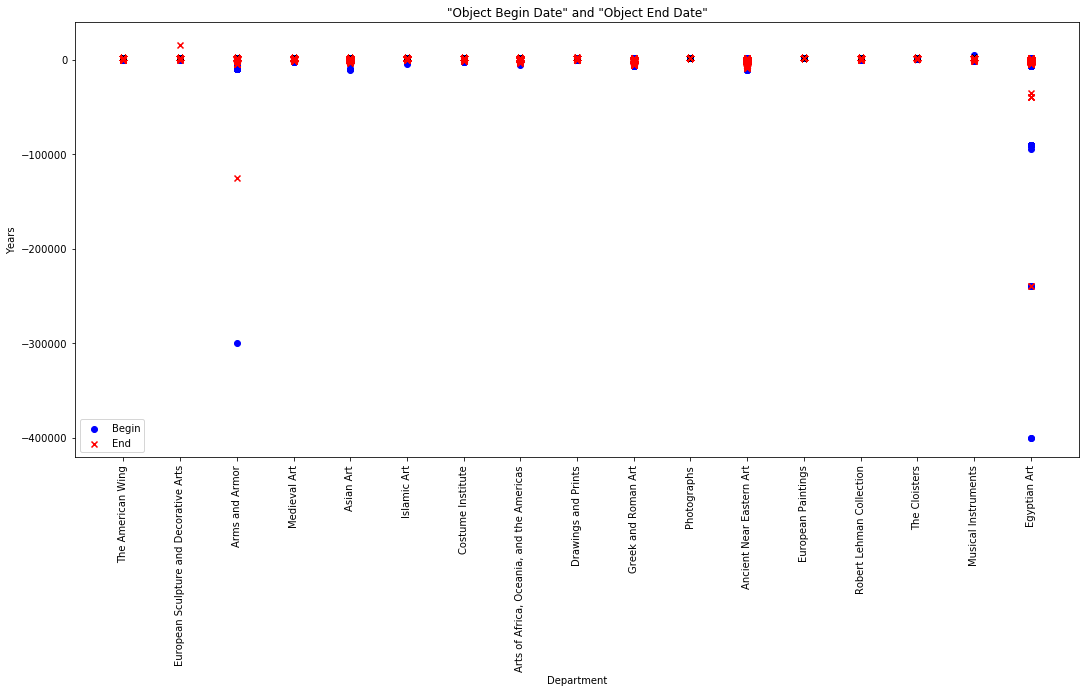

In [30]:
plt.figure(figsize=(18,8))
plt.scatter(df['Department'], df['Object Begin Date'], color='b', label='Begin')
plt.scatter(df['Department'], df['Object End Date'], color='r', marker='x', label='End')

# Figure formatting
plt.ylabel('Years')
plt.xlabel('Department')
plt.legend()
plt.xticks(rotation=90)
plt.title('"Object Begin Date" and "Object End Date"')
plt.show()

In terms of maximum, let's remove any data points with dates after 2020.

In terms of minimum, it is trickier, let's have a look at the data points in detail.

In [31]:
df.drop(df[df['Object Begin Date']>2020].index, inplace=True)
df.drop(df[df['Object End Date']>2020].index, inplace=True)

In [32]:
df[df['Object Begin Date']<-50000][['Department','AccessionYear','Classification','Artist Display Name','Culture','Country']]

,Department,AccessionYear,Classification,Artist Display Name,Culture,Country
196770,Egyptian Art,1906.0,Tool,NaN,NaN,Egypt
196772,Egyptian Art,1906.0,Miscellaneous,NaN,NaN,Egypt
196773,Egyptian Art,1906.0,Other,NaN,NaN,Egypt
196774,Egyptian Art,1906.0,Miscellaneous,NaN,NaN,Egypt
196776,Egyptian Art,1906.0,Tool,NaN,NaN,Egypt
196784,Egyptian Art,1906.0,Tool,NaN,NaN,Egypt
197542,Egyptian Art,1925.0,Tool,NaN,NaN,Egypt
197543,Egyptian Art,1925.0,Other,NaN,NaN,Egypt
197544,Egyptian Art,1925.0,Tool,NaN,NaN,Egypt
197545,Egyptian Art,1925.0,Other,NaN,NaN,Egypt


I cannot conclude these extremely low values for years are incorrect or outliers. Thus, I will keep them as is.

Let's see a more focused version of the previously graph however, for curiosity.

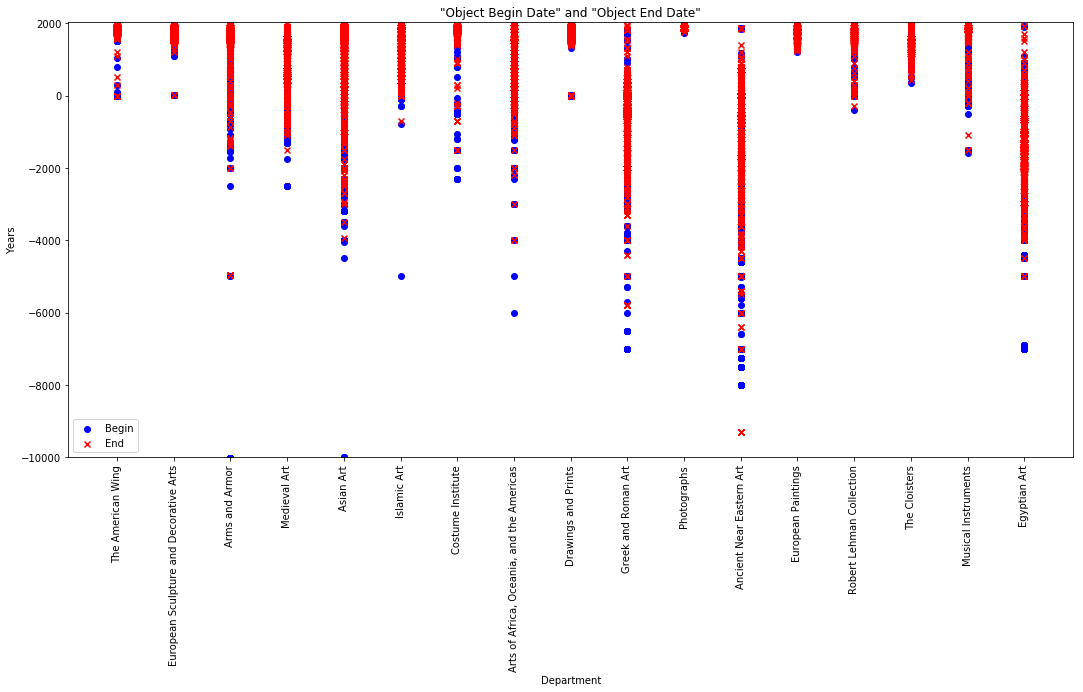

In [33]:
plt.figure(figsize=(18,8))
plt.scatter(df['Department'], df['Object Begin Date'], color='b', label='Begin')
plt.scatter(df['Department'], df['Object End Date'], color='r', marker='x', label='End')

# Figure formatting
plt.ylabel('Years')
plt.xlabel('Department')
plt.ylim(-10000,2020)
plt.legend()
plt.xticks(rotation=90)
plt.title('"Object Begin Date" and "Object End Date"')
plt.show()

I can see that each department spans over different periods of time, different both in absolute value but also in duration. 
Let's try another visualization to gain more insights into each of their distribution.

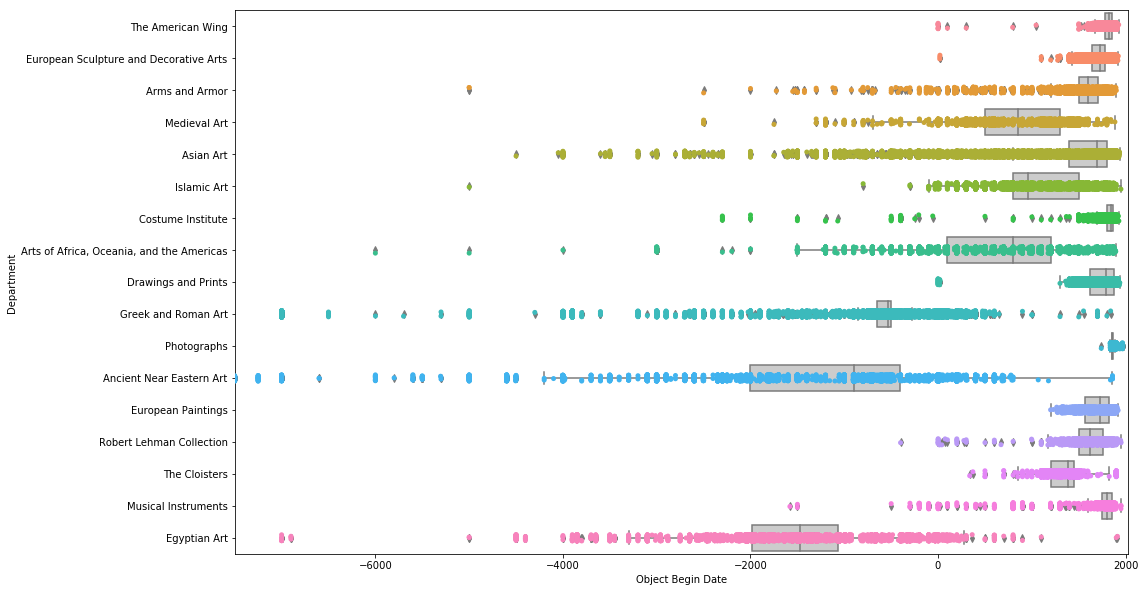

In [34]:
fig, ax = plt.subplots(figsize=(16,10))

sns.boxplot(x=df['Object Begin Date'], y=df['Department'], color=".8",ax=ax)
sns.stripplot(x=df['Object Begin Date'], y=df['Department'], ax=ax)
plt.xlim(-7500, 2020) 
plt.show()

Let's try again another format to visualize the feature AccessionYear against the target variable Department. I am also curious to see the representation of the boolean feature 'Is Timeline Work', which is defined in the documentation as *whether the object is on the Timeline of Art History website*.

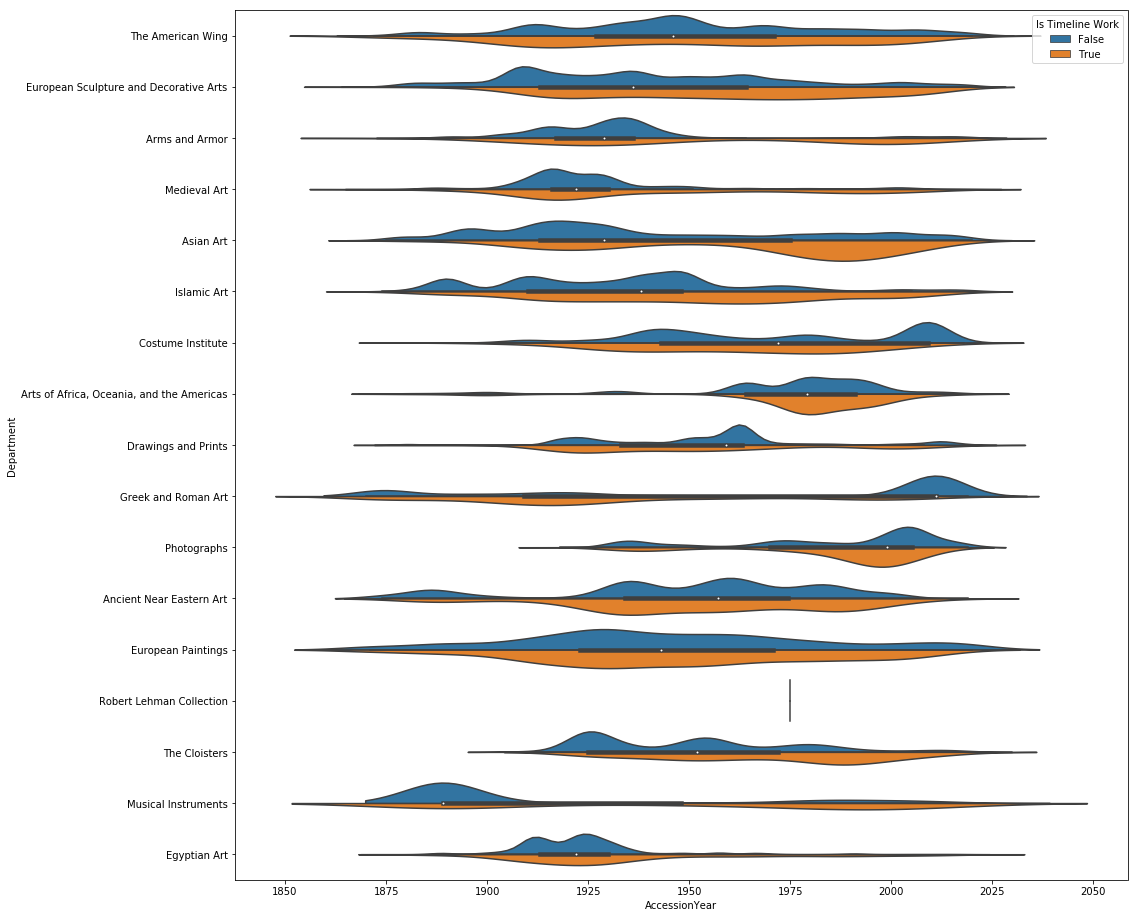

In [35]:
fig, ax = plt.subplots(figsize=(16,16))
sns.violinplot(x='AccessionYear', y='Department', hue='Is Timeline Work', split=True, data=df, ax=ax);

In [36]:
df['Object Date'].value_counts().head(20)

18th century                              8855
19th century                              7868
17th century                              4372
18th–19th century                         3202
1888                                      2792
16th century                              2788
second quarter of the 5th century B.C.    2144
ca. 1888                                  2035
early 19th century                        1954
1880s                                     1800
probably 8th–12th century                 1722
1890                                      1609
6th/5th centuries B.C.                    1608
1887                                      1459
1889                                      1303
15th century                              1242
n.d.                                      1079
500–480 B.C.                              1068
late 18th century                         1034
490–480 B.C.                               998
Name: Object Date, dtype: int64

Finally, considering this last feature 'Object Date', its content is too diverse to be standardized unfortunately. It is removed from the dataframe. 

It seems the three features 'AccessionYear', 'Object Begin Date', 'Object End Date' contain in a standardized manner enough timely information about each piece. 

In [37]:
df.drop(columns=['Object Date'], inplace=True)

### Artist infos : Artist Role, Artist Prefix, Artist Display Name, Artist Display Bio, Artist Suffix, Artist Alpha Sort, Artist Nationality, Artist Begin Date, Artist End Date, Artist Gender, Artist ULAN URL, Artist Wikidata URL

Let's start by grouping in a list the features names relative to the artist.

In [38]:
artists = ['Artist Role','Artist Prefix','Artist Display Name','Artist Display Bio','Artist Suffix','Artist Alpha Sort','Artist Nationality',
           'Artist Begin Date', 'Artist End Date','Artist Gender','Artist ULAN URL','Artist Wikidata URL']

for feat in artists: 
    print(round(df[feat].notna().sum()/df.shape[0]*100,2), '% of non-null values in feature', feat)
    

print('\nThere is ', df[artists[2]].nunique(), 'unique values for the Artist Display Name')

41.51 % of non-null values in feature Artist Role
15.23 % of non-null values in feature Artist Prefix
42.24 % of non-null values in feature Artist Display Name
36.52 % of non-null values in feature Artist Display Bio
2.17 % of non-null values in feature Artist Suffix
42.23 % of non-null values in feature Artist Alpha Sort
28.38 % of non-null values in feature Artist Nationality
36.7 % of non-null values in feature Artist Begin Date
36.79 % of non-null values in feature Artist End Date
13.06 % of non-null values in feature Artist Gender
32.07 % of non-null values in feature Artist ULAN URL
24.26 % of non-null values in feature Artist Wikidata URL

There is  23381 unique values for the Artist Display Name


The first observation is the relatively low percentage of data points where artist's information are known. These percentages are slightly troubling. Nevertheless, let's carry on by investigating the most represented (and known) artists in the Met datacase with Open Access.

In [39]:
df[artists[2]].value_counts().head(20)

Allen & Ginter                                         2960
Goodwin & Company                                      2647
W. Duke, Sons & Co.                                    2248
Brewster & Co.                                         1671
Unknown                                                 850
Anonymous, British, 19th century                        744
Albrecht Dürer                                          716
Utagawa Hiroshige                                       671
Anonymous                                               668
Kinney Brothers Tobacco Company                         655
Jacques Callot|Israël Henriet                           555
James McNeill Whistler                                  509
Jules-Edmond-Charles Lachaise|Eugène-Pierre Gourdet     488
W. Duke, Sons & Co.|Knapp & Company                     462
Meissen Manufactory                                     457
Stefano della Bella                                     453
Anonymous, French, 18th century         

A few observations are made here. 
- Some of the most represented artists are actually companies 
- There is a significant number of unknown or anonymous artists
- Anonymous artists are sometimes detailed with their nationality and century
- There is a pattern of using a vertical bar "|" when referencing more than one person or organization

Let's have a look at a few entries attributed to the artist Albrecht Dürer. 

In [40]:
df[df[artists[2]]=='Albrecht Dürer'][artists].head()

,Artist Role,Artist Prefix,Artist Display Name,Artist Display Bio,Artist Suffix,Artist Alpha Sort,Artist Nationality,Artist Begin Date,Artist End Date,Artist Gender,Artist ULAN URL,Artist Wikidata URL
61257,Artist,After a composition by,Albrecht Dürer,"German, Nuremberg 1471–1528 Nuremberg",NaN,"Dürer, Albrecht",German,1471,1528,NaN,http://vocab.getty.edu/page/ulan/500115493,https://www.wikidata.org/wiki/Q5580
61404,Maker,Style of,Albrecht Dürer,"German, Nuremberg 1471–1528 Nuremberg",NaN,"Dürer, Albrecht",German,1471,1528,NaN,http://vocab.getty.edu/page/ulan/500115493,https://www.wikidata.org/wiki/Q5580
118435,Artist,NaN,Albrecht Dürer,"German, Nuremberg 1471–1528 Nuremberg",NaN,"Dürer, Albrecht",German,1471,1528,NaN,http://vocab.getty.edu/page/ulan/500115493,https://www.wikidata.org/wiki/Q5580
118436,Artist,NaN,Albrecht Dürer,"German, Nuremberg 1471–1528 Nuremberg",NaN,"Dürer, Albrecht",German,1471,1528,NaN,http://vocab.getty.edu/page/ulan/500115493,https://www.wikidata.org/wiki/Q5580
118438,Artist,NaN,Albrecht Dürer,"German, Nuremberg 1471–1528 Nuremberg",NaN,"Dürer, Albrecht",German,1471,1528,NaN,http://vocab.getty.edu/page/ulan/500115493,https://www.wikidata.org/wiki/Q5580


Let's have a look at data points having a anonymous or "|" in their artist group of features.

In [41]:
df[df['Artist Display Name'].str.contains(pat='Anonymous', case=False, na=False)][artists].head(10)

,Artist Role,Artist Prefix,Artist Display Name,Artist Display Bio,Artist Suffix,Artist Alpha Sort,Artist Nationality,Artist Begin Date,Artist End Date,Artist Gender,Artist ULAN URL,Artist Wikidata URL
11622,Mount maker,NaN,Anonymous,NaN,NaN,Anonymous,NaN,NaN,NaN,NaN,NaN,NaN
11624,Mount maker,NaN,Anonymous,NaN,NaN,Anonymous,NaN,NaN,NaN,NaN,NaN,NaN
11625,Mount maker,NaN,Anonymous,NaN,NaN,Anonymous,NaN,NaN,NaN,NaN,NaN,NaN
71216,Artist,NaN,"Anonymous, German, 17th century",NaN,NaN,"Anonymous, German, 17th century",German,1600,1700,NaN,NaN,NaN
71340,Artist,NaN,"Anonymous, Swiss",NaN,NaN,"Anonymous, Swiss",Swiss,1400,2050,NaN,NaN,NaN
83044,Artist,Attributed to an,"Anonymous Workshop, British",NaN,", London","Anonymous Workshop, British",British,NaN,NaN,NaN,NaN,NaN
83249,Artist,Attributed to an,"Anonymous Workshop, British",NaN,", London","Anonymous Workshop, British",British,NaN,NaN,NaN,NaN,NaN
83250,Artist,Attributed to an,"Anonymous Workshop, British",NaN,", London","Anonymous Workshop, British",British,NaN,NaN,NaN,NaN,NaN
84274,Artist,Attributed to an,"Anonymous Workshop, British",NaN,", London","Anonymous Workshop, British",British,NaN,NaN,NaN,NaN,NaN
86347,Artist|Maker|Designer,With elements after a design on a woodcut by|W...,Jost Amman|Anonymous Flemish weavers|Anonymous...,"Swiss, Zurich before 1539–1591 Nuremberg",NaN,"Amman, Jost|Anonymous Flemish weavers|Anonymou...",Swiss,1539 |1500,1591 |1600,||,http://vocab.getty.edu/page/ulan/500115433||,||


In [42]:
df[df['Artist Role'].str.contains(pat='\|', case=False, na=False)][artists].tail(10)

,Artist Role,Artist Prefix,Artist Display Name,Artist Display Bio,Artist Suffix,Artist Alpha Sort,Artist Nationality,Artist Begin Date,Artist End Date,Artist Gender,Artist ULAN URL,Artist Wikidata URL
239334,Maker|Artist,NaN,Thomas Chippendale|Robert Adam,"British, baptised Otley, West Yorkshire 1718–1...",NaN,"Chippendale, Thomas|Adam, Robert",NaN,1718 |1728,1779 |1792,|,http://vocab.getty.edu/page/ulan/500015768|htt...,https://www.wikidata.org/wiki/Q314278|https://...
239335,Maker|Designer,Supplied by,Thomas Chippendale|Robert Adam,"British, baptised Otley, West Yorkshire 1718–1...",NaN,"Chippendale, Thomas|Adam, Robert",NaN,1718 |1728,1779 |1792,|,http://vocab.getty.edu/page/ulan/500015768|htt...,https://www.wikidata.org/wiki/Q314278|https://...
239336,Maker|Designer,Supplied by,Thomas Chippendale|Robert Adam,"British, baptised Otley, West Yorkshire 1718–1...",NaN,"Chippendale, Thomas|Adam, Robert",NaN,1718 |1728,1779 |1792,|,http://vocab.getty.edu/page/ulan/500015768|htt...,https://www.wikidata.org/wiki/Q314278|https://...
239337,Maker|Designer,NaN,Thomas Chippendale|Robert Adam,"British, baptised Otley, West Yorkshire 1718–1...",NaN,"Chippendale, Thomas|Adam, Robert",NaN,1718 |1728,1779 |1792,|,http://vocab.getty.edu/page/ulan/500015768|htt...,https://www.wikidata.org/wiki/Q314278|https://...
239338,Maker|Designer,Supplied by,Thomas Chippendale|Robert Adam,"British, baptised Otley, West Yorkshire 1718–1...",NaN,"Chippendale, Thomas|Adam, Robert",NaN,1718 |1728,1779 |1792,|,http://vocab.getty.edu/page/ulan/500015768|htt...,https://www.wikidata.org/wiki/Q314278|https://...
239339,Maker|Designer,NaN,Thomas Chippendale|Robert Adam,"British, baptised Otley, West Yorkshire 1718–1...",NaN,"Chippendale, Thomas|Adam, Robert",NaN,1718 |1728,1779 |1792,|,http://vocab.getty.edu/page/ulan/500015768|htt...,https://www.wikidata.org/wiki/Q314278|https://...
239341,Artist|Calligrapher,NaN,Chōbunsai Eishi|Shokusanjin (Ōta Nanpo),"Japanese, 1756–1829|Japanese, 1749–1823",NaN,Chōbunsai Eishi,NaN,1756 |1749,1829 |1823,|,http://vocab.getty.edu/page/ulan/500121365|,https://www.wikidata.org/wiki/Q2972127|
239344,Artist|Etcher,After,Raphael (Raffaello Sanzio or Santi)|Wenceslaus...,"Italian, Urbino 1483–1520 Rome|Bohemian, Pragu...",NaN,"Raphael (Raffaello Sanzio or Santi)|Hollar, We...",NaN,1483 |1607,1520 |1677,|,http://vocab.getty.edu/page/ulan/500023578|htt...,https://www.wikidata.org/wiki/Q5597|
239346,Artist|Artist|Sitter,After,Hans Holbein the Younger|Wenceslaus Hollar|Han...,"German, Augsburg 1497/98–1543 London|Bohemian,...",NaN,"Holbein, Hans, the Younger|Hollar, Wenceslaus|...",NaN,1497 |1607 |1497,1543 |1677 |1543,||,http://vocab.getty.edu/page/ulan/500005259|htt...,https://www.wikidata.org/wiki/Q48319||https://...
239347,Artist|Artist|Artist|Artist|Artist|Artist|Arti...,NaN,Suzuki Shōnen 鈴木松年|Tomioka Tessai 富岡鉄斎|Murase ...,"Japanese, 1849–1918|Japanese, 1836–1924|Japane...",NaN,Suzuki Shōnen|Tomioka Tessai|Murase Gyokuden|A...,NaN,1849 |1836 |1852 |1824 |18...,1918 |1924 |1917 |1894 |18...,|||||||||||||||,http://vocab.getty.edu/page/ulan/500123383|htt...,||||https://www.wikidata.org/wiki/Q3201302||||...


For the anonymous artists, I decide to standardize the display name. It appears the nationality and century related to these anonymous artists, when available, are well referenced in the proper feature 'Artist nationality' and 'Artist Begin Date'/'Artist End Date' respectively. Also, I will replace "Unknown" with "Anonymous".

For the data points referencing several people or organization in their artists group of feature, the situation is a little bit more critical. The best would be to extract a single name corresponding to the artist. Potentially, other features could be created in order to store other relating person, for example the publisher or editor as shows above. I am not sure at the moment how to perform this cleaning and will keep brain storming about it. Let's just check how many data points are in this case.


Percentage of art pieces link to more than 1 person/organization:  12.77 %


Percentage of art pieces link to more than 1 person/organisation per department
The American Wing -->  4.53 %
European Sculpture and Decorative Arts -->  9.31 %
Arms and Armor -->  2.02 %
Medieval Art -->  0.09 %
Asian Art -->  1.31 %
Islamic Art -->  1.64 %
Costume Institute -->  1.05 %
Arts of Africa, Oceania, and the Americas -->  0.03 %
Drawings and Prints -->  40.06 %
Greek and Roman Art -->  0.15 %
Photographs -->  24.18 %
Ancient Near Eastern Art -->  0.0 %
European Paintings -->  0.74 %
Robert Lehman Collection -->  3.7 %
The Cloisters -->  0.26 %
Musical Instruments -->  1.45 %
Egyptian Art -->  0.08 %


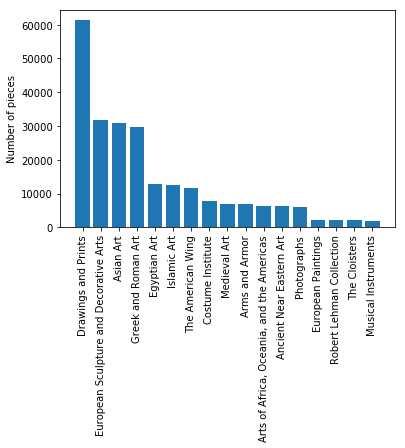

In [43]:
print('Percentage of art pieces link to more than 1 person/organization: ',
      round(df['Artist Role'].str.contains(pat='\|', case=False, na=False).sum()/df.shape[0]*100,2),"%")

print('\n')

print('Percentage of art pieces link to more than 1 person/organisation per department')
for dep in df['Department'].unique().tolist():
    total = df[(df['Artist Role'].str.contains(pat='\|', case=False, na=False)) & (df['Department']==dep)]['Department'].count()
    print(dep, "--> ", round(total/df[df['Department']==dep]['Department'].count()*100,2),"%")
    
plt.bar(x = df[['Object ID','Department']].groupby('Department').count().sort_values(by='Object ID', ascending=False).index, 
        height = df[['Object ID','Department']].groupby('Department').count().sort_values(by='Object ID', ascending=False)['Object ID'])
plt.xticks(rotation=90)
plt.ylabel('Number of pieces')
plt.show()

Classes are imbalanced, in particular the most represented one is 'Drawings and Prints'. I have thus decided to remove all samples from this department that show more than one person related. Besides being a simple cleaning task, it helps balance a little the classes.

In [44]:
df.drop(df[(df['Artist Role'].str.contains(pat='\|', case=False, na=False)) & (df['Department']=='Drawings and Prints')].index,inplace=True)

Other affected classes are not all so well represented already. Thus, I try to come up with a simple strategy to clean these artists related features.

However, before deciding of the fate for some of the features relating to artists, let's quickly display what value is currently used in the feature about gender.

In [45]:
# Display unique values of the feature Artist Gender
df[artists[9]].unique()

array([nan, '|', '||||', '|||', '||', 'Female|Female', '|Female',
       'Female', 'Female|', 'Female||', '|Female|', '||||||||',
       '|||||||||||||||||||||||||||', 'Female|||', '|||Female',
       '||Female', '||Female|', '||||||', '|Female|||', '|||||',
       '||||||||||', '||||||||||||||||', '|||||||', '||||||||||||',
       '|||||||||||||||', '|||||||||||||', '||Female||Female||',
       '|Female|Female|Female', '|||||||||', '|||||Female||',
       '||Female||||||', '|||||Female', '|||||||||||||||||||'],
      dtype=object)

Apparently, only Female is registered in the feature Artist Gender. Arguably, I will consider that who is not 'Female', is 'Male' and fill in missing value with this reasoning. We clearly see here again that some data points have several persons or organizations associated with them.

Considering the percentage of missing values as well as the potential use of each of these artists feature, I decide to only keep in my dataframe: Artist Role, Artist Display Name, Artist Nationality, and Artist Gender. I am still undecided what to do with the features 'Artist Begin Date' and 'Artist End Date'. Beside keeping it as is, I could try to calculate the age of the artist by substracting End to Begin. 

Manipulations to do on artists features:

- Some pieces have more than one person linked to them. Their information are separeted with "|". I will need to extract information relative to the artist at least
- on Artist Display Name: simplify to Anonymous all mention of it. 
- on Artist Gender: set to "Female" whenever it appears, otherwise 'Male' --> encode 0/1

I have spend a considerable amount of time considering what to do when multiple persons are linked to a piece. In this process, I looked in detail at the feature 'Artist Role' and wanted to understand the motivation to put the person in a certain order. The table below helped me in this consideration. My conclusion was to take the first occurence of person, assuming they listed first the most important person to reference. 

In [46]:
multipleA = df[df['Artist Role'].str.contains(pat='\|', case=False, na=False)]['Artist Role'] 
table_multipleA = pd.DataFrame([])
for i in np.arange(5):
    table_multipleA = pd.concat([table_multipleA, multipleA.str.split(pat='\|', expand=True)[i].value_counts()],axis=1,sort=False)

table_multipleA.head(25)

,0,1,2,3,4
Artist,2340.0,1713.0,281.0,113.0,39.0
Manufactory,1138.0,415.0,110.0,48.0,6.0
Maker,837.0,773.0,174.0,54.0,17.0
Designer,347.0,344.0,49.0,33.0,24.0
Modeler,262.0,222.0,35.0,3.0,3.0
Factory,125.0,86.0,8.0,NaN,1.0
Manufacturer,100.0,142.0,18.0,1.0,NaN
Decorator,93.0,563.0,145.0,18.0,2.0
Calligrapher,67.0,83.0,19.0,1.0,NaN
Factory director,65.0,279.0,74.0,10.0,1.0


In [47]:
# Select only the first occurence in the list of person
for featA in ['Artist Role','Artist Display Name','Artist Nationality','Artist Gender','Artist Begin Date','Artist End Date']:
    df[featA] = df[featA].str.split(pat='|',expand=True)[0]

In [48]:
# Complete the feature gender
df['Artist Gender'].fillna('Male', inplace=True)
df['Artist Gender'].replace(to_replace='',value='Male',inplace=True)

In [49]:
# Simplify slightly the feature role using the function defined above (in the classification part)
group_few_values('Artist Role',10)

df['Artist Role'].replace(to_replace='',value='Other',inplace=True)
df['Artist Role'].fillna(value='Unkown',inplace=True)

Number of unique values for the column Artist Role : 45


In [50]:
# Generalize slightly the feature nationality
df['Artist Nationality'] = df['Artist Nationality'].str.split(pat=',',
                                                              expand=True)[0].str.split(pat=' \(',
                                                                                        expand=True)[0].str.split(pat=' or',
                                                                                                                  expand=True)[0].str.split(pat='?',
                                                                                                                                           expand=True)[0]

df['Artist Nationality'].replace(to_replace='Alsatian',value='French',inplace=True)
df['Artist Nationality'].replace(to_replace='Paris',value='French',inplace=True)
df['Artist Nationality'].replace(to_replace='possibly French',value='French',inplace=True)
df['Artist Nationality'].replace(to_replace='French(',value='French',inplace=True)
df['Artist Nationality'].replace(to_replace='French ',value='French',inplace=True)
df['Artist Nationality'].replace(to_replace='France',value='French',inplace=True)

df['Artist Nationality'].replace(to_replace='German-born sculptor later active in Switzerland',value='German',inplace=True)
df['Artist Nationality'].replace(to_replace='Hanoverian',value='German',inplace=True)
df['Artist Nationality'].replace(to_replace='Southern Germany',value='German',inplace=True)
df['Artist Nationality'].replace(to_replace='Aachen',value='German',inplace=True)
df['Artist Nationality'].replace(to_replace='Upper Rhine',value='German',inplace=True)
df['Artist Nationality'].replace(to_replace='Germany',value='German',inplace=True)
df['Artist Nationality'].replace(to_replace='Geman',value='German',inplace=True)

df['Artist Nationality'].replace(to_replace='Naples',value='Italian',inplace=True)
df['Artist Nationality'].replace(to_replace='Lombard',value='Italian',inplace=True)
df['Artist Nationality'].replace(to_replace='Veronese',value='Italian',inplace=True)
df['Artist Nationality'].replace(to_replace='Southern Italy',value='Italian',inplace=True)
df['Artist Nationality'].replace(to_replace='Florence',value='Italian',inplace=True)
df['Artist Nationality'].replace(to_replace='Siena',value='Italian',inplace=True)
df['Artist Nationality'].replace(to_replace='Siena ',value='Italian',inplace=True)
df['Artist Nationality'].replace(to_replace='Sienese',value='Italian',inplace=True)
df['Artist Nationality'].replace(to_replace='Tuscany',value='Italian',inplace=True)
df['Artist Nationality'].replace(to_replace='Venetian',value='Italian',inplace=True)
df['Artist Nationality'].replace(to_replace='Emilian',value='Italian',inplace=True)
df['Artist Nationality'].replace(to_replace='Italian [search purposes only]',value='Italian',inplace=True)
df['Artist Nationality'].replace(to_replace='Italian ',value='Italian',inplace=True)

df['Artist Nationality'].replace(to_replace='Continental/Swiss',value='Swiss',inplace=True)
df['Artist Nationality'].replace(to_replace='probably Swiss',value='Swiss',inplace=True)

df['Artist Nationality'].replace(to_replace='Belgium',value='Belgian',inplace=True)

df['Artist Nationality'].replace(to_replace='South Netherlandish',value='Netherlandish',inplace=True)
df['Artist Nationality'].replace(to_replace='North Netherlandish',value='Netherlandish',inplace=True)
df['Artist Nationality'].replace(to_replace='Southern Netherlands',value='Netherlandish',inplace=True)

df['Artist Nationality'].replace(to_replace='possibly Iranian',value='Iranian',inplace=True)
df['Artist Nationality'].replace(to_replace='Iran',value='Iranian',inplace=True)

df['Artist Nationality'].replace(to_replace='Democratic Republic of Congo',value='Congo',inplace=True)
df['Artist Nationality'].replace(to_replace='Dem. Republic of the Congo',value='Congo',inplace=True)

df['Artist Nationality'].replace(to_replace='Chiricahua Apache Native American',value='Native American',inplace=True)

df['Artist Nationality'].replace(to_replace='Paris and London',value='European',inplace=True)
df['Artist Nationality'].replace(to_replace='Netherlandish/French',value='European',inplace=True)
df['Artist Nationality'].replace(to_replace='French and English',value='European',inplace=True)
df['Artist Nationality'].replace(to_replace='Franco-Flemish',value='European',inplace=True)
df['Artist Nationality'].replace(to_replace='French Italian',value='European',inplace=True)
df['Artist Nationality'].replace(to_replace='British/Irish',value='European',inplace=True)
df['Artist Nationality'].replace(to_replace='Maltese',value='European',inplace=True)
df['Artist Nationality'].replace(to_replace='Netherlandish / French',value='European',inplace=True)
df['Artist Nationality'].replace(to_replace='French/Flemish',value='European',inplace=True)
df['Artist Nationality'].replace(to_replace='Scandinavian',value='European',inplace=True)
df['Artist Nationality'].replace(to_replace='Northern European',value='European',inplace=True)
df['Artist Nationality'].replace(to_replace='Central European',value='European',inplace=True)
df['Artist Nationality'].replace(to_replace='Franco-Netherlandish',value='European',inplace=True)

df['Artist Nationality'].replace(to_replace='Africa',value='African',inplace=True)
df['Artist Nationality'].replace(to_replace='Uganda',value='African',inplace=True)
df['Artist Nationality'].replace(to_replace='Sierra Leone',value='African',inplace=True)
df['Artist Nationality'].replace(to_replace='South Africa',value='African',inplace=True)
df['Artist Nationality'].replace(to_replace='West Coast Africa',value='African',inplace=True)
df['Artist Nationality'].replace(to_replace='Cameroon',value='African',inplace=True)
df['Artist Nationality'].replace(to_replace='Cameroon',value='African',inplace=True)

dict_Anation = {'Khitan':'Other', 
                'Franco-American':'Other', 
                'British American':'Other', 
                'Brabant':'Other', 
                'Roman':'Other', 
                'Manchu':'Other', 
                'Guatemalan':'Other', 
                'Georgian':'Other', 
                'American born Britain':'Other', 
                'Byzantine':'Other', 
                'Tibetan':'Other', 
                'Czech':'Other'}
df['Artist Nationality'].replace(to_replace=dict_Anation,inplace=True)

df['Artist Nationality'].fillna(value='Unknown',inplace=True)

group_few_values('Artist Nationality',10)

Number of unique values for the column Artist Nationality : 31


In [51]:
# Treat the artist's name feature
# First simplify the artist name containing Anonymous by only 'Anonymous'
Uanonym = df['Artist Display Name'][df['Artist Display Name'].str.contains(pat='Anonymous',case=False,na=False)].unique().tolist()
zip1 = zip(Uanonym, ['Anonymous']*len(Uanonym))
dict_Anonym = dict(zip1)
df['Artist Display Name'].replace(to_replace=dict_Anonym, inplace=True)
df['Artist Display Name'].replace(to_replace='Other',value='Anonymous', inplace=True)
df['Artist Display Name'].replace(to_replace='Unidentified Artist',value='Anonymous', inplace=True)
df['Artist Display Name'].replace(to_replace='Unknown',value='Anonymous', inplace=True)

# Fill missing names by 'Anonymous'
df['Artist Display Name'].fillna('Anonymous',inplace=True)

# Number of unique artist names
print(df['Artist Display Name'].nunique())

# Simplify this feature, keeping only artists name when they appear more than 20 times.
group_few_values('Artist Display Name',20)
df['Artist Display Name'].replace(to_replace='Other',value='Anonymous', inplace=True)

12659
Number of unique values for the column Artist Display Name : 463


In [52]:
# Adapt some dates from the format YYYY-MM-DD or YYYY-DD-MM to only YYYY
df['Artist Begin Date'] = df['Artist Begin Date'].str.split(pat='.\-',expand=True)[0]
df['Artist End Date'] = df['Artist End Date'].str.split(pat='.\-',expand=True)[0]

# Change column data type to numeric
df['Artist Begin Date'] = pd.to_numeric(df['Artist Begin Date'])
df['Artist End Date'] = pd.to_numeric(df['Artist End Date'])

# Adapt End Date for value above 2020
df.loc[df['Artist End Date'] > 2020, 'Artist End Date'] = 2020

In [53]:
df[['Artist Begin Date','Artist End Date']].describe()

,Artist Begin Date,Artist End Date
count,64474.000000,64697.000000
mean,1713.735087,1788.017080
std,170.896089,180.902043
min,-1279.000000,-1213.000000
25%,1626.000000,1700.000000
50%,1756.000000,1828.000000
75%,1822.000000,1900.000000
max,1950.000000,2020.000000


In [54]:
# Simplify this information with a new feature 'Artist century'
df['Artist Century'] = (df['Artist Begin Date'] + (df['Artist End Date'] - df['Artist Begin Date'])/2)
df.loc[df['Artist End Date'] == 2020, 'Artist Century'] = df['Artist Begin Date']
df.loc[df['Artist Century'] > 2020, 'Artist Century'] = df['Artist Begin Date']
df['Artist Century'] = np.floor(df['Artist Century']/100 +1)

df['Artist Century'].describe()

count    64438.000000
mean        17.963764
std          1.726160
min        -12.000000
25%         17.000000
50%         18.000000
75%         19.000000
max         20.000000
Name: Artist Century, dtype: float64

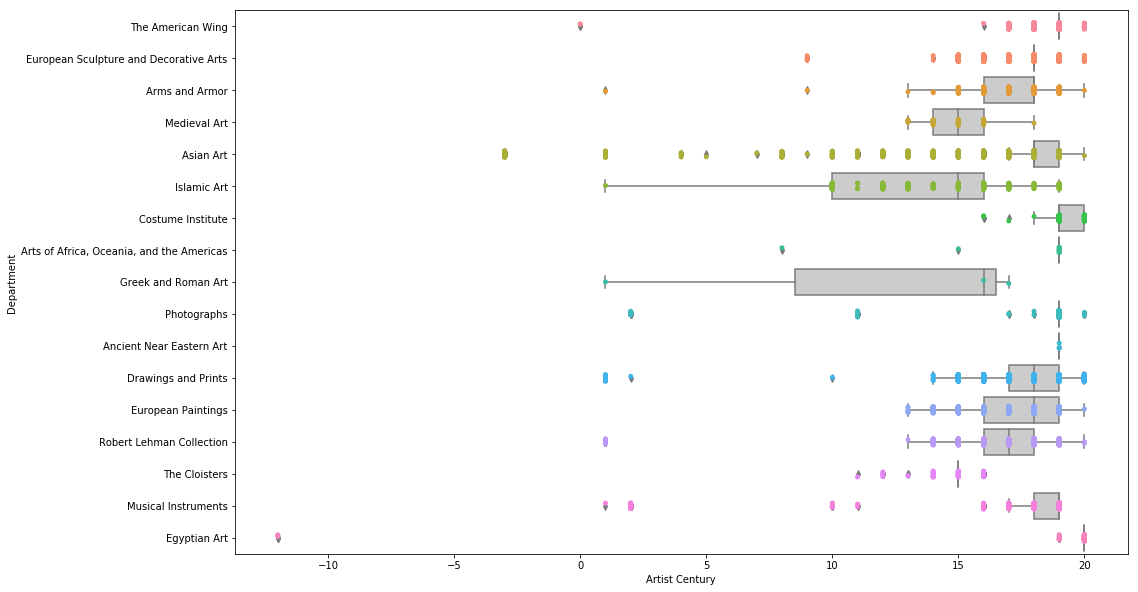

In [55]:
fig, ax = plt.subplots(figsize=(16,10))

sns.boxplot(x=df['Artist Century'], y=df['Department'], color=".8",ax=ax)
sns.stripplot(x=df['Artist Century'], y=df['Department'], ax=ax);

In [56]:
df['Artist Begin Date'].fillna(df['Artist Begin Date'].median(),inplace=True)
df['Artist End Date'].fillna(df['Artist End Date'].median(),inplace=True)
df['Artist Century'].fillna(df['Artist Century'].median(),inplace=True)

In [57]:
df.drop(columns=['Artist Prefix','Artist Display Bio','Artist Suffix','Artist Alpha Sort','Artist ULAN URL','Artist Wikidata URL'], inplace=True)

### Medium, Dimensions

Let's have a quick look at these two features describing the physical property of the pieces of art.

Number of unique values in the feature "Medium": 34373


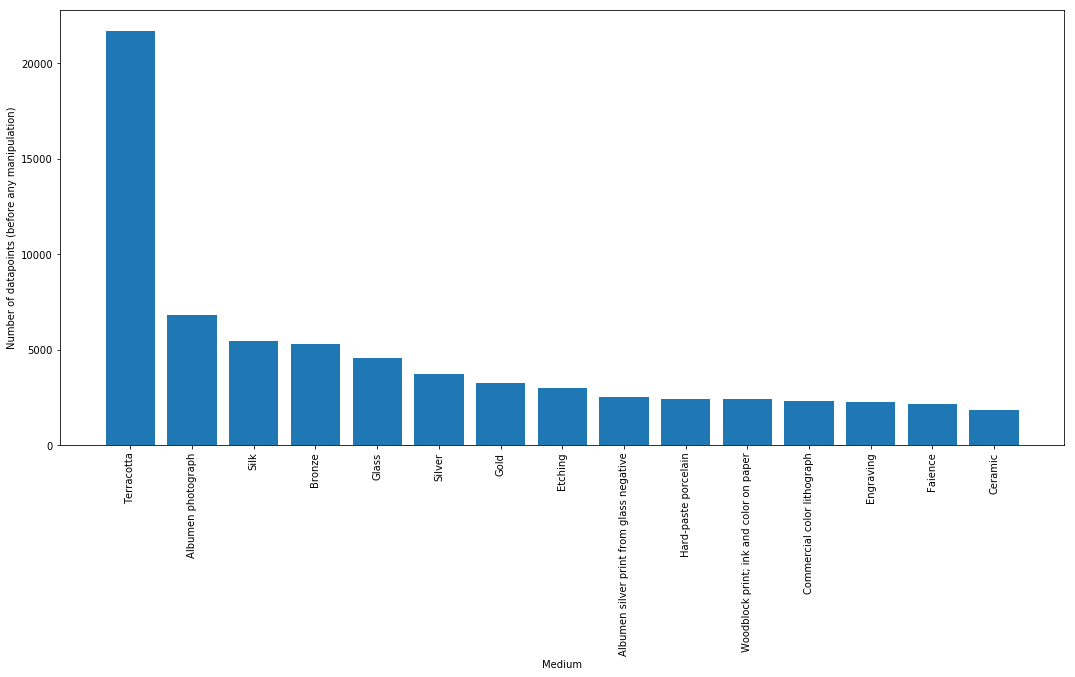

In [58]:
print('Number of unique values in the feature "Medium":', df.Medium.nunique() )

medium_top15 = pd.DataFrame(df['Medium'].value_counts()).head(15)

plt.figure(figsize=(18,8))
plt.bar(x=medium_top15.index, height=medium_top15['Medium'])
plt.xticks(rotation=90)

# Figure formatting
plt.xlabel('Medium')
plt.ylabel('Number of datapoints (before any manipulation)')
plt.show()

We observe that there are a high number of different type of Medium recorded in the dataframe. To some extent, I would like to standardize or generalize this feature, meaning regroup some of these values into more general categories. For example, to adapt to 'Gold' an entry that would have 'Gold, garnets with foil backings, silver studs/rivets'. This is a simplification and for sure it will loose part of the information, however for the model it does not seem to make sense to have hundreds of entries with their own detailed Medium category.

In [59]:
# First set NaN to 'Unknown'
df['Medium'].fillna('Unknown',inplace=True)
# Simplify
df['Medium'] = df['Medium'].str.split(pat=',',expand=True)[0].str.split(pat=';',expand=True)[0]
df['Medium'].replace(to_replace='[no medium available]',value='Unknown',inplace=True)
df['Medium'] = df['Medium'].str.replace(pat=' (?)',repl='',regex=False)
df['Medium'] = df['Medium'].str.replace(pat='(?)',repl='',regex=False)
df['Medium'] = df['Medium'].str.replace(pat=' ?',repl='',regex=False)
df['Medium'] = df['Medium'].str.replace(pat='?',repl='',regex=False)

I go further with the cleaning, in an iterative way. I consider the top (40) occurences and assign less common value containing these occurences to them. 

In [60]:
df['Medium'].replace(to_replace='silk',value='Silk',inplace=True)
df['Medium'].replace(to_replace='Silk and metal thread',value='Silk',inplace=True)
df['Medium'].replace(to_replace='Silk / Compound weave',value='Silk',inplace=True)
df['Medium'].replace(to_replace='Woodcut',value='Wood',inplace=True)
df['Medium'].replace(to_replace='Woodblock print',value='Wood',inplace=True)
df['Medium'].replace(to_replace='Pen and brown ink',value='Pen and ink',inplace=True)
df['Medium'].replace(to_replace='Hand-colored etching',value='Etching',inplace=True)
df['Medium'].replace(to_replace='Copper alloy',value='Copper',inplace=True)
df['Medium'].replace(to_replace='Copper alloy',value='Copper',inplace=True)
df['Medium'].replace(to_replace='Hard-paste porcelain',value='Porcelain',inplace=True)
df['Medium'].replace(to_replace='Soft-paste porcelain',value='Porcelain',inplace=True)
df['Medium'].replace(to_replace='cotton',value='Cotton',inplace=True)
df['Medium'].replace(to_replace='Salted paper print from paper negative',value='Salted paper print',inplace=True)

dict_Medium ={}
list_main_medium = df['Medium'].value_counts().head(40).index.tolist()
list_medium = ['Silk','Porcelain','Ivory','Chalk','Clay','Wood','Bone','Cotton','Limestone','Copper']
for med in list_main_medium: 
    U_med = df['Medium'][df['Medium'].str.contains(pat=med,case=False,na=False)].unique().tolist()
    print(med)
    zip_med = zip(U_med, [med]*len(U_med))
    
    dict_Medium = {**dict_Medium, **dict(zip_med)}

df['Medium'].replace(to_replace=dict_Medium, inplace=True)

Terracotta
Silk
Wood
Albumen photograph
Bronze
Glass
Porcelain
Etching
Silver
Gold
Pen and ink
Steel
Earthenware
Engraving
Cotton
Limestone
Ceramic
Copper
Albumen silver print from glass negative
Faience
Commercial color lithograph
Iron
Pen and black ink
Linen
Oil on canvas
Wool
Stone
Ivory
Stucco
Unknown
Bobbin lace
Graphite
Pottery
Ink
Stonepaste
Salted paper print
Marble
Brass
Clay
Hanging scroll


I did a visual check of the values and decided to regroup again some medium. 

In [61]:
dict_Medium ={}
list_medium = ['Chalk','Mahogany','Gouache','Charcoal','Polychrome','Serpentine','Pencil', 'Watercolor', 'Jade','Lithograph','Bone','Parchment',
               'Canvas','Horn','Plaster','Papyrus','Pine','Quartz','Walnut','Steatite','Feather','Fiber','Lacquer','Leather','Skin','Satin','Album',
               'Maple','Agate','Handscroll','Oak','Shell','Bamboo','Lead','Leaf','Pearl']
for med in list_medium: 
    U_med = df['Medium'][df['Medium'].str.contains(pat=med,case=False,na=False)].unique().tolist()
    #print(med)
    zip_med = zip(U_med, [med]*len(U_med))
    
    dict_Medium = {**dict_Medium, **dict(zip_med)}

df['Medium'].replace(to_replace=dict_Medium, inplace=True)

Finally, I group values present only a few times (below 20) into one category 'Other'

In [62]:
group_few_values('Medium',20)

Number of unique values for the column Medium : 185


Let's have a look at the feature "Dimensions".

In [63]:
df['Dimensions'].head(10)

0    24 3/8 x 14 5/8 x 5 1/8 in. (61.9 x 37.1 x 13 cm)
1                                  H. 12 in. (30.5 cm)
2                              H. 12 3/8 in. (31.4 cm)
3                          11 x 9 in. (27.9 x 22.9 cm)
4        H. 6 9/16 in. (16.7 cm); Diam. 3 in. (7.6 cm)
5    H. 6 1/4 in. (15.9 cm); Diam. 2 15/16 in. (7.5...
6     30 7/8 x 25 x 13 7/8 in. (78.4 x 63.5 x 35.2 cm)
7     30 7/8 x 25 x 13 7/8 in. (78.4 x 63.5 x 35.2 cm)
8                                  H. 27 in. (68.6 cm)
9                                  H. 27 in. (68.6 cm)
Name: Dimensions, dtype: object

Dimensions is currently a categorical feature, which is probably not very useful. Thus, the idea would be to extract the numerical information and store it in a new numerical features. However, this will not be an easy task as the values are currently not completely standardized and might require some  assumptions to cut and extract numbers out of the text. For example, I will want to extract numbers that appear just before the unit "cm", sometimes in brackets etc. 

In performing the API requests for images below, I realized that dimensions were also stored differently in the website. I thus decided to carry on with the cleaning here and perform image and dimensions retrieval in a side script. The treatment of this feature is addressed at the end of all cleaning.

### Culture, Period, Dynasty, Reign, Portfolio

For these four features, it appears the large majority of rows are missing information. 

In [64]:
cultural = ['Culture','Period','Dynasty','Reign', 'Portfolio']

for feat in cultural: 
    print(round(df[feat].notna().sum()/df.shape[0]*100,2), '% of non-null values in feature', feat)
    
print('\nThere is ', df[cultural[0]].nunique(), 'unique values for the feature Culture')

65.22 % of non-null values in feature Culture
32.53 % of non-null values in feature Period
4.97 % of non-null values in feature Dynasty
2.63 % of non-null values in feature Reign
1.19 % of non-null values in feature Portfolio

There is  4883 unique values for the feature Culture


In [65]:
df['Culture'].value_counts().head(10)

Greek, Attic    16798
Japan           15010
American        11796
China           10654
French           8597
Italian          4340
Roman            3672
British          3526
Japanese         2412
German           2368
Name: Culture, dtype: int64

In [66]:
df['Period'].value_counts().head()

Edo period (1615–1868)      8464
Archaic                     7305
Classical                   6561
New Kingdom                 3431
Qing dynasty (1644–1911)    3167
Name: Period, dtype: int64

Considering how few pieces have a value in the columns 'Dynasty', 'Reign' and 'Portfolio', I have decided to remove them. 

For the feature 'Period', it is defined in the Met documentation that it refers to "Time or time period when an object was created". As such, I will assume the features about time already discussed above are sufficiantly representing this kind of information about the art pieces.

Thus, I am left with the colum "Culture" only. I might want to standardize a little bit this column by grouping some values together. For example an entry "Spanish, Valencia (Manises)" is adapted to simply "Spanish". The idea is to focus on more general categories rather than too detailed ones. All pieces missing the information will be given the value 'unknown'.

In [67]:
df.drop(columns=['Period', 'Dynasty', 'Reign', 'Portfolio'],inplace=True)

In [68]:
df['Culture'].value_counts().tail()

Tanzanian               1
Indo-Portuguese, Goa    1
Indian, Malabar         1
Panuco                  1
North or West India     1
Name: Culture, dtype: int64

In [69]:
# First set NaN to 'Unknown'
df['Culture'].fillna('Unknown',inplace=True)

In [70]:
# remove probably, possibly, after "for", after "/", "and" ?, put the rest into "other" ?
df['Culture'] = df['Culture'].str.split(pat=',',expand=True)[0].str.split(pat=' \(',expand=True)[0].str.split(pat=' or',expand=True)[0]
df['Culture'] = df['Culture'].str.split(pat=';',expand=True)[0].str.split(pat=' and ',expand=True)[0].str.split(pat=' for ',expand=True)[0]
df['Culture'] = df['Culture'].str.replace(pat='probably ', repl='', case=False).str.replace(pat='possibly ', repl='', case=False)
df['Culture'] = df['Culture'].str.replace(pat='Southern ', repl='', case=False).str.replace(pat='Southwest ', repl='', case=False)
df['Culture'] = df['Culture'].str.replace(pat='Northern ', repl='', case=False).str.replace(pat='Northwest ', repl='', case=False)
df['Culture'] = df['Culture'].str.replace(pat='South ', repl='', case=False).str.replace(pat='North ', repl='', case=False)
df['Culture'] = df['Culture'].str.replace(pat='(?)',repl='',regex=False).str.replace(pat='?',repl='')

In [71]:
group_few_values('Culture',20)

Number of unique values for the column Culture : 190


### Location : Geography Type, City, State, County, Country, Region, Subregion, Locale, Locus, Excavation, River

Let's investivate the geographical features.

In [72]:
geo = ['Geography Type','City','State','County','Country','Region','Subregion','Locale','Locus','Excavation','River']

g_table =[]
for g in geo: 
    g_table.append([g, round(df[g].notna().sum()/df.shape[0],2), df[g].nunique()])
    
g_table = pd.DataFrame(data=g_table, columns=['Feature','Fraction of non-null values','Number of unique values'])
g_table

,Feature,Fraction of non-null values,Number of unique values
0,Geography Type,0.18,99
1,City,0.07,1412
2,State,0.01,85
3,County,0.02,753
4,Country,0.21,655
5,Region,0.09,402
6,Subregion,0.06,300
7,Locale,0.04,643
8,Locus,0.02,1005
9,Excavation,0.04,309


In [73]:
df[geo[0]].value_counts().head(20)

Made in                              12299
From                                 12235
Attributed to                         6299
Excavated in                          2950
Probably made in                       786
Possibly made in|Possibly made in      428
Found                                  413
From|Probably from                     339
Found/excavated                        316
Possibly made in                       209
Country of Origin                      185
From|Possibly from                     131
Original from                          111
From|Mint                              111
From|Said to be from                   103
Excavated in|Attributed to              70
Excavated in|Mint                       65
Probably from                           53
Said to be from                         49
Made in|Made in                         38
Name: Geography Type, dtype: int64

Unfortunately, many features have very few values, and as such will probably not be helpful and will be removed. Two columns however stands out and will be kept: 
- Geography Type; but it will be simplified to more general values. For example, the idea is to identify objects that have been excavated. 
- Country; multiple values will be removed and only 1 country will be considered

Missing values in 'Geography Type' and 'Country' are replaced by 'Unknown'.

In [74]:
df.drop(columns=['City','State','County','Region','Subregion','Locale','Locus','Excavation','River'],inplace=True)
df['Geography Type'].fillna('Unknown',inplace=True)
df['Country'].fillna('Unknown',inplace=True)

In [75]:
# Geography Type --> manual matching / cleaning
df['Geography Type'] = df['Geography Type'].str.split(pat='|',expand=True)[0]
df['Geography Type'] = df['Geography Type'].str.replace(pat='(none assigned)',repl='Unknown',regex=False)
df['Geography Type'].replace(to_replace='',value='Unknown',inplace=True)

df['Geography Type'].replace(to_replace='Possibly made in',value='Probably made in',inplace=True)

df['Geography Type'].replace(to_replace='Made in',value='From',inplace=True)

df['Geography Type'].replace(to_replace='Found/excavated',value='Excavated in',inplace=True)

df['Geography Type'].replace(to_replace='Probably originally from',value='Probably made in',inplace=True)
df['Geography Type'].replace(to_replace='Possibly from',value='Probably made in',inplace=True)
df['Geography Type'].replace(to_replace='Presumably from',value='Probably made in',inplace=True)
df['Geography Type'].replace(to_replace='Said to be from',value='Probably made in',inplace=True)
df['Geography Type'].replace(to_replace='Probably from',value='Probably made in',inplace=True)

df['Geography Type'].replace(to_replace='Original',value='Original from',inplace=True)
df['Geography Type'].replace(to_replace='Country of Origin',value='Original from',inplace=True)

df['Geography Type'].replace(to_replace='Object place',value='Unknown',inplace=True)
df['Geography Type'].replace(to_replace='Made for',value='Unknown',inplace=True)
df['Geography Type'].replace(to_replace='Mint',value='Unknown',inplace=True)
df['Geography Type'].replace(to_replace='Decorated in',value='Unknown',inplace=True)

df['Geography Type'].value_counts()

Unknown                        176835
From                            25438
Attributed to                    6373
Excavated in                     3408
Probably made in                 1725
Found                             417
Original from                     298
Formerly considered made in        34
Name: Geography Type, dtype: int64

Let's clean and slightly simplify the feature 'Country'

In [76]:
df['Country'] = df['Country'].str.split(pat='|',expand=True)[0]
df['Country'] = df['Country'].str.split(pat=' or',expand=True)[0]
df['Country'] = df['Country'].str.split(pat=',',expand=True)[0]
df['Country'] = df['Country'].str.split(pat=' and',expand=True)[0]
df['Country'] = df['Country'].str.split(pat=' \(',expand=True)[0]
df['Country'] = df['Country'].str.split(pat=' \/',expand=True)[0]
df['Country'] = df['Country'].str.replace(pat='possibly ',repl='',case=False)
df['Country'] = df['Country'].str.replace(pat='(possibly)',repl='',case=False,regex=False)
df['Country'] = df['Country'].str.replace(pat='probably ',repl='',case=False)
df['Country'] = df['Country'].str.replace(pat='(probably)',repl='',case=False,regex=False)
df['Country'] = df['Country'].str.replace(pat='(?)',repl='',case=False,regex=False)
df['Country'] = df['Country'].str.replace(pat=' ?',repl='',case=False,regex=False)
df['Country'] = df['Country'].str.replace(pat='?',repl='',case=False,regex=False)
df['Country'] = df['Country'].str.replace(pat='present-day ',repl='',case=False)
df['Country'] = df['Country'].str.replace(pat='modern-day ',repl='',case=False)
df['Country'] = df['Country'].str.replace(pat='southern ',repl='',case=False)
df['Country'] = df['Country'].str.replace(pat='eastern ',repl='',case=False)
df['Country'] = df['Country'].str.replace(pat='northern ',repl='',case=False)
df['Country'] = df['Country'].str.replace(pat='western ',repl='',case=False)
df['Country'] = df['Country'].str.replace(pat='central ',repl='',case=False)
df['Country'] = df['Country'].str.replace(pat='North ',repl='',case=False)
df['Country'] = df['Country'].str.replace(pat='Northwest ',repl='',case=False)
df['Country'] = df['Country'].str.replace(pat='South ',repl='',case=False)
df['Country'] = df['Country'].str.replace(pat='NorthIran ',repl='Iran',case=False)
df['Country'] = df['Country'].str.replace(pat=' possibly',repl='',case=False)

In [77]:
group_few_values('Country',5)

Number of unique values for the column Country : 94


### Tags

Let's have a look at the feature 'Tags'. 

In [78]:
print('Percentage of non-null values: ', round(df.Tags.notna().sum()/df.shape[0]*100,1), '%, and the number of unique sets of tags is', df.Tags.nunique())
df['Tags'].value_counts().head(10)

Percentage of non-null values:  62.1 %, and the number of unique sets of tags is 31272


Flowers                      6008
Portraits|Women|Actresses    3598
Men|Portraits                2639
Men                          2540
Flowers|Leaves               1757
Bowls                        1683
Women                        1661
Carriages                    1651
Birds                        1629
Bottles                      1546
Name: Tags, dtype: int64

In [79]:
Tags = df['Tags'].str.split(pat='|',expand=True)
print('Size of dataframe after expanding: ', Tags.shape)
Tags = Tags.stack(dropna=True)
Tags = Tags.reset_index(drop=True)
print('Size of dataframe after stacking: ', Tags.shape)

Tags.value_counts().head(20)

Size of dataframe after expanding:  (214528, 18)
Size of dataframe after stacking:  (269414,)


Men              27973
Women            20224
Flowers          14690
Portraits        12785
Birds             6399
Leaves            5081
Trees             4732
Actresses         4388
Human Figures     4246
Landscapes        3819
Profiles          3639
Animals           3385
Bowls             2731
Athletes          2451
Architecture      2419
Coat of Arms      2325
Bottles           2257
Horse Riding      2209
Baseball          2161
Carriages         1992
dtype: int64

Let's visualize these tages with a wordcloud, the idea is to print out the tags with sizes corresponding to their number of occurences

In [80]:
!pip install wordcloud

Sources for this visualization

Tutorial: 
https://www.datacamp.com/community/tutorials/wordcloud-python

Documentation: 
https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html

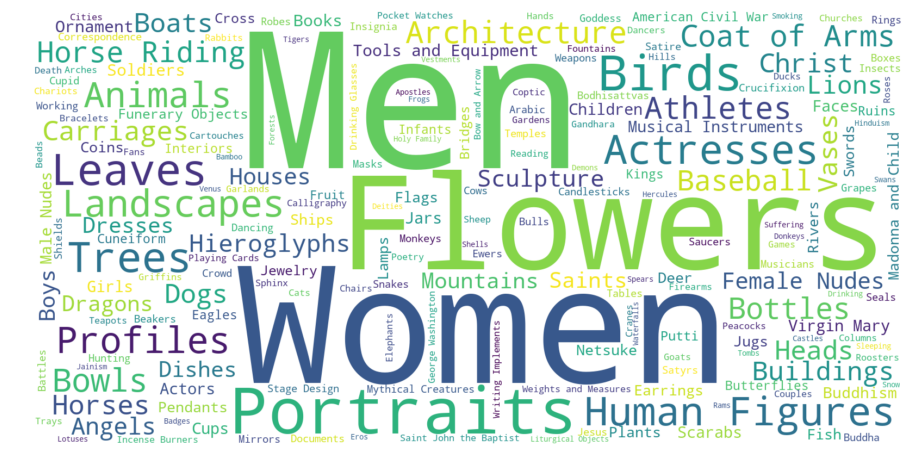

In [81]:
# Import package
from wordcloud import WordCloud, STOPWORDS

# Create and generate a word cloud image:
wordcloud = WordCloud(width=1600, height=800, background_color="white").generate_from_frequencies(Tags.value_counts())

# Display the generated image:
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [82]:
df['Tags'] = df['Tags'].str.split(pat='|',expand=True)[0]

group_few_values('Tags',30)

df['Tags'].fillna('Other',inplace=True)

Number of unique values for the column Tags : 355


With this feature 'Tags', the motivation is to identify which subjects are represented in the art pieces of the Met museums. From the wordcloud above, I observe that art pieces quite often depict human subjects; women, men, portraits, etc. 


### Constiuent ID, Credit Line, Rights and Reproduction, Link Resource, Object Wikidata URL, Metadata Date, Tags AAT URL, Tags Wikidata URL

Finally, these last features are very interesting to store in a museum database. However, they are unlikely to bring much useful information to the model. They will be removed from the dataframe.

In [83]:
df.drop(columns=['Constiuent ID', 'Credit Line', 'Rights and Reproduction', 'Link Resource', 'Object Wikidata URL', 
                 'Metadata Date', 'Repository', 'Tags AAT URL', 'Tags Wikidata URL'], 
        inplace=True)

### Dimensions from API requests

As explained above the feature dimensions was treated separately by performing requests to the MET website. The table with treated numbers is imported here and joined with the main dataframe.

For this treatment, it was necessary to have a record of all 'Object ID' upon which to run a request. The file recorded this is created below.

In [84]:
df['Object ID'].to_csv('sel_ObjectID.txt',index=False,header=False)

In [85]:
API_file = pd.read_csv('API_file.txt')
API_file.head()

,measurements,objectID,primaryImageSmall,Depth,Height,Width,Diameter,Length,Weight,Thickness,Caliber,Other,Foot,Rim,Base,Body,Circumference,Capacity,Neck
0,"'Depth': 13.0175, 'Height': 61.9, 'Width': 37.1",34.0,https://images.metmuseum.org/CRDImages/ad/web-...,13.0175,61.9000,37.10,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,'Height': 30.5,37.0,https://images.metmuseum.org/CRDImages/ad/web-...,0.0000,30.5000,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,'Height': 31.4,38.0,https://images.metmuseum.org/CRDImages/ad/web-...,0.0000,31.4000,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"'Height': 27.9, 'Width': 22.86",39.0,https://images.metmuseum.org/CRDImages/ad/web-...,0.0000,27.9000,22.86,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"'Diameter': 7.62, 'Height': 16.6688",40.0,https://images.metmuseum.org/CRDImages/ad/web-...,0.0000,16.6688,0.00,7.62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's make the list of features to transfer.

In [86]:
list_dim = API_file.columns.tolist()
list_dim.remove('measurements')
list_dim.remove('primaryImageSmall')
list_dim

['objectID',
 'Depth',
 'Height',
 'Width',
 'Diameter',
 'Length',
 'Weight',
 'Thickness',
 'Caliber',
 'Other',
 'Foot',
 'Rim',
 'Base',
 'Body',
 'Circumference',
 'Capacity',
 'Neck']

In [87]:
df = df.merge(API_file[list_dim], left_on='Object ID', right_on='objectID',how='inner')

I decided to do an 'inner' merge instead of 'left' to remove any point that might have faced issues in the request process.

Let's do a final cleaning, removing unnecessary field and visualize the distribution of one dimensional feature (Height) over the departments.

In [88]:
df.drop(columns=['Is Timeline Work','Dimensions','objectID'],inplace=True)

In [89]:
list_dim.remove('objectID')
df[list_dim].describe()

,Depth,Height,Width,Diameter,Length,Weight,Thickness,Caliber,Other,Foot,Rim,Base,Body,Circumference,Capacity,Neck
count,214480.000000,214480.000000,214480.000000,214480.000000,214480.000000,214480.000000,214480.000000,214480.000000,214480.000000,214480.000000,214480.000000,214480.000000,214480.000000,214480.000000,214480.000000,214480.000000
mean,1.827481,20.695521,15.734553,1.133928,3.070880,0.620300,0.020651,0.000020,0.002203,0.002965,0.003855,0.000689,0.001247,0.005417,0.000702,0.000038
std,11.087640,119.239682,45.387480,5.116914,93.064895,47.644666,0.463796,0.004541,0.253820,0.150310,0.184704,0.090927,0.094504,0.769023,0.185568,0.012420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,7.620015,3.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,22.860000,18.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,804.200000,42532.000000,5420.400000,238.700000,41592.582000,12928.266000,132.080300,1.140000,66.040130,18.097536,29.210058,22.542545,13.335027,210.820420,60.960120,4.318008


In [90]:
df['Tot_dimensions'] = df[list_dim].sum(axis=1)

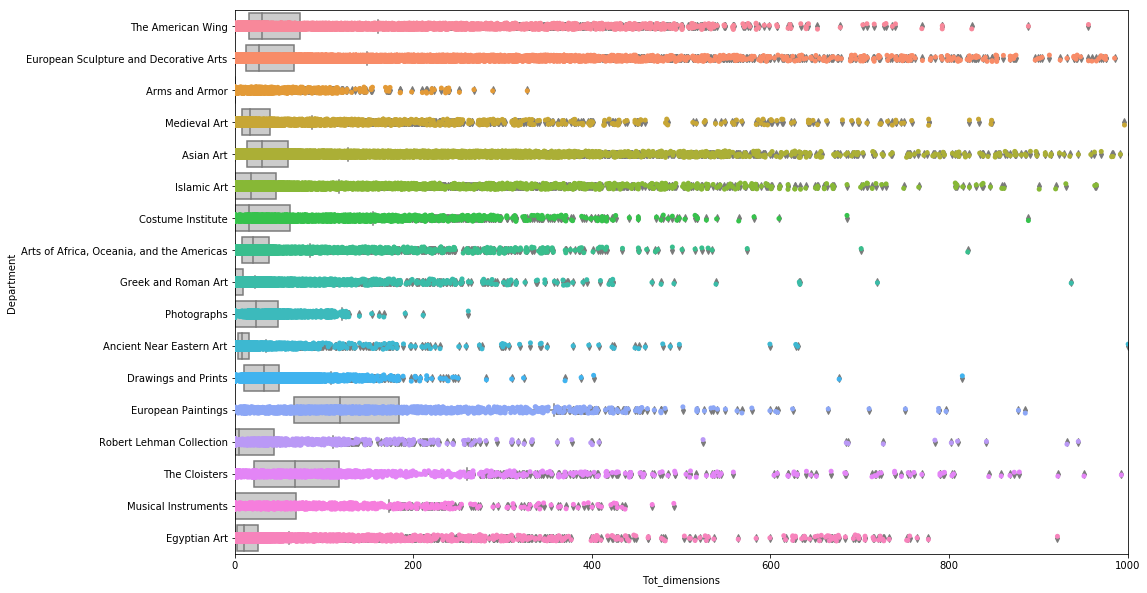

In [91]:
fig, ax = plt.subplots(figsize=(16,10))

sns.boxplot(x=df['Tot_dimensions'], y=df['Department'], color=".8",ax=ax)
sns.stripplot(x=df['Tot_dimensions'], y=df['Department'], ax=ax)
plt.xlim(0, 1000) 
plt.show()

A first important observation is that the table is very sparse.

One dimension alone does not seem to descriminate drastically between the department. However, the combinations of different measures might be more effective. Consequently, a new feature 'Tot_dimensions' was created by summing all dimensions together, regardless of their type.

## DataFrame after data cleaning and manipulation

The dataframe after cleaning and manipulation looks like this:

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214480 entries, 0 to 214479
Data columns (total 37 columns):
Is Highlight           214480 non-null bool
Object ID              214480 non-null int64
Gallery Number         214480 non-null int64
Department             214480 non-null object
AccessionYear          214480 non-null float64
Culture                214480 non-null object
Artist Role            214480 non-null object
Artist Display Name    214480 non-null object
Artist Nationality     214480 non-null object
Artist Begin Date      214480 non-null float64
Artist End Date        214480 non-null float64
Artist Gender          214480 non-null object
Object Begin Date      214480 non-null int64
Object End Date        214480 non-null int64
Medium                 214480 non-null object
Geography Type         214480 non-null object
Country                214480 non-null object
Classification         214480 non-null object
Tags                   214480 non-null object
Artist Century    

In [93]:
feats = df.columns.tolist()
feats_table = pd.DataFrame(columns=['Feature','UniqueV','DType'])

for feat in feats:
    line = pd.DataFrame(data=[[feat,df[feat].nunique(),df[feat].dtype]],columns=['Feature','UniqueV','DType'])
    feats_table = feats_table.append(line,ignore_index=True)
    
feats_table.set_index('Feature', inplace=True)
feats_table

,UniqueV,DType
Feature,,
Is Highlight,2,bool
Object ID,214480,int64
Gallery Number,369,int64
Department,17,object
AccessionYear,152,float64
Culture,190,object
Artist Role,45,object
Artist Display Name,462,object
Artist Nationality,31,object


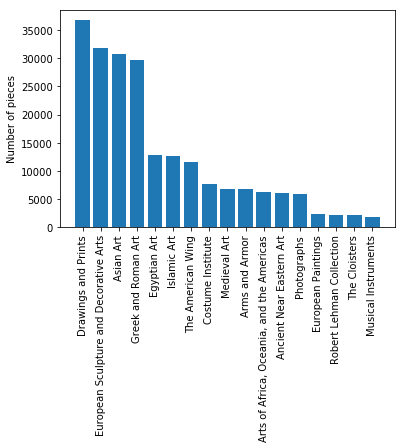

In [94]:
plt.bar(x = df[['Object ID','Department']].groupby('Department').count().sort_values(by='Object ID', ascending=False).index, 
        height = df[['Object ID','Department']].groupby('Department').count().sort_values(by='Object ID', ascending=False)['Object ID'])
plt.xticks(rotation=90)
plt.ylabel('Number of pieces')
plt.show()

For the first machine learning task, I remove the four smallest categories: 'European Paintings','Robert Lehman Collection','The Cloisters' and 'Musical Instruments'. However, I want to keep those points for the second machine learning task about object type or 'Classification'.

Thus, the number of samples for this task will be:  

In [95]:
df_ML1 = df.drop(df[df.Department == 'European Paintings'].index)
df_ML1.drop(df_ML1[df_ML1.Department == 'Robert Lehman Collection'].index, inplace=True)
df_ML1.drop(df_ML1[df_ML1.Department == 'The Cloisters'].index, inplace=True)
df_ML1.drop(df_ML1[df_ML1.Department == 'Musical Instruments'].index, inplace=True)

print('For the first task, the number of samples will be:',df_ML1.shape[0], '. These samples are described by', df_ML1.shape[1], 'features')

For the first task, the number of samples will be: 205803 . These samples are described by 37 features


In [96]:
# Save this first selection to a text file to be used in the ML1-ChristelCHAPPUIS.ipynb notebook
df_ML1.to_csv('df_ML1.txt',index=False)

The number of target variables is: 13 labels


## Retrieve images of art pieces

For the second machine learning task, I will make a small selection of objects based on a balanced representation of the feature 'Classification'.

Then, let's quickly have a look at the procedure to retrieve one image from the MET online database. First, get the ID from the DataFrame, then use MET API to retrieve the url and requests the image. This procedure is inspired by the documentation in https://metmuseum.github.io/ --> Object request by object ID

I want to show 1 picture per target. 

But firstly, let's make the selection. I decide to make a selection of 6 target labels. The points belong to the categories: Coin, Swords, Stone Sculpture, Earrings, Paintings, Dress. In doing so, I try to have relatively different classes that seem to be relatively easy to distinguish. My motivation for this second task is rather to test different feature extractor from TensorFlow Hub.

In [97]:
df_sel = df[df['Classification'].isin(['Coin','Swords','Stone Sculpture','Earrings','Paintings','Dress'])]
df_sel.shape

(10238, 37)

As this represents still too many images for my system to process, I will later make a finer and balanced selection of 100 points per class. 

I propose the following selection steps:
- For 'Coin': remove any points where the culture is unknown
- For 'Paintings': keep only 'European Paintings' from a known artist
- For 'Dress': from 'Costume Institute', with length greater than 0, and tagged as dress

Given the relative differences between the categories, I hope using images only will be enough for the model to perform well. However, if necessary, I plan to use the metadata in addition to the images. In that case, I will not use the feature 'Department' and 'Tags'.

In [98]:
df_sel = df_sel.loc[~((df_sel['Classification'] == 'Paintings') & (df_sel['Department'] == 'European Paintings')),:]
df_sel = df_sel.loc[~((df_sel['Classification'] == 'Paintings') & (df_sel['Artist Display Name'] == 'Anonymous')),:]

df_sel = df_sel.loc[~((df_sel['Classification'] == 'Coin') & (df_sel['Culture'] == 'Unknown')),:]

df_sel = df_sel.loc[~((df_sel['Classification'] == 'Dress') & (df_sel['Department'] != 'Costume Institute')),:]
df_sel = df_sel.loc[~((df_sel['Classification'] == 'Dress') & (df_sel['Length'] == 0)),:]
df_sel = df_sel.loc[~((df_sel['Classification'] == 'Dress') & (df_sel['Tags'] != 'Dresses')),:]

In [99]:
df_sel.Classification.value_counts()

Stone Sculpture    933
Paintings          792
Dress              696
Swords             373
Coin               262
Earrings           189
Name: Classification, dtype: int64

Paintings


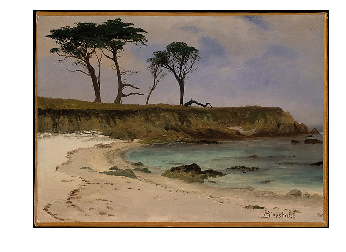

Swords


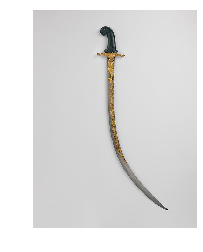

Coin


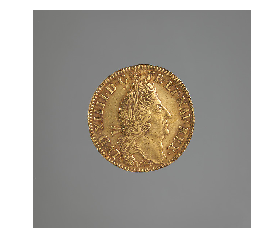

Dress


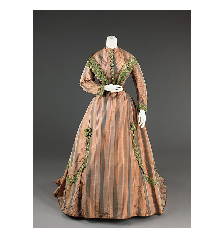

Earrings


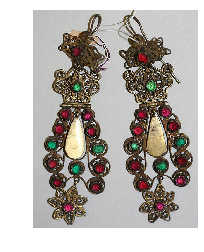

Stone Sculpture


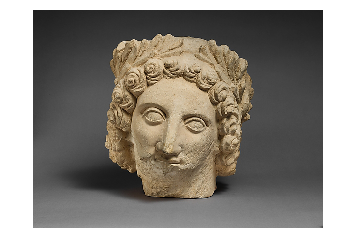

In [100]:
class_values = df_sel.Classification.unique().tolist()
df_ML2 = pd.DataFrame([])

for cla in class_values:
    # Select 100 points from this class
    df_ML2 = df_ML2.append(df_sel[df_sel['Classification']==cla].sample(n=100,axis=0,random_state=1))
    
    # Retrieve the url
    ID = df_ML2[df_ML2['Classification']==cla]['Object ID'].iloc[0]
    url = API_file[API_file.objectID==ID]['primaryImageSmall'].tolist()[0]
    # Create the file name
    ImageFile= str(cla)+'.png' 
    print(cla)
    
    # Make the request for the image
    i_f = open(ImageFile, "wb") 
    r = requests.get(url)
    i_f.write(r.content)
    i_f.close()
    
    # Load the image using PIL
    pillow_img = Image.open(ImageFile)
    # Convert into Numpy array
    img = np.array(pillow_img)
    # Plot the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [101]:
df_sel = df_sel.merge(API_file[['objectID','primaryImageSmall']], left_on='Object ID', right_on='objectID',how='inner')
df_sel.dropna(axis=0,how='any',inplace=True)
df_sel.shape

(3243, 39)

In [102]:
# Save this second selection to a text file to be used in the ML2-ChristelCHAPPUIS.ipynb notebook
df_sel.to_csv('df_ML2.txt',index=False)

This second dataset will contain 100 points for each target variable, so a total of 600 images.

# Discussion

The dataset contains a majority of categorical features. This is not ideal for a machine learning and thus several manipulations have been required to extract some numerical features as well as generalize some categorical features. This was for sure an important challenge in this Jupyter notebook for data preparation and exploration. I am very curious to see what results can be achieved with this dataset. 

To summarize, I plan to tackle two machine learning tasks with this dataset:
- "Where is this art piece ?" --> predict the department responsible for the art piece, given relevant meta information about the piece
- "What is this art piece ?" --> predict the classification or type (e.g. painting, sculpture, etc) of art piece, given its image

For the first task "Where is this art piece?", I plan to test a variety of models learned in the course 4: Logistic regression, k nearest neighbors, decision trees, random forests and support vector machine. 

For the second task "What is this art piece?", I want to compare different pretrained models from TensorFlow Hub. The idea is to find out if these pretrained models can identify art pieces. I will apply these models to extract high-level features first, followed by a "simple" classification with one chosen model (knn).

Finally, I tried to define a project that can show as much the skills learned in the first two course (data analysis) and the last two (machine learning). I am particularly curious to see how models perform on a subject and dataset that is mostly represented by categorical, text values.